# **1. Сбор данных**

### Сначало попробовали через API тянуть данные (Finnhub.io), но американские акции убрали из бесплатного доступа Finnhub.io
Альтернатива - **yfinance** (источник - Yahoo Finance)


In [ ]:
pip install yfinance --upgrade

In [1]:
import yfinance as yf
import pandas as pd


def get_ohlcv(
    tickers,
    start="2024-01-01",
    end="2025-10-14",
    interval="1d",  # можно "1m", "1h", "1wk", "1mo"
    save_to_csv=False,
    long_format=True  # сплющить многоуровневую структуру
):
    """
    Загружает OHLCV-данные по списку тикеров с Yahoo Finance.
    """

    df = yf.download(
        tickers=tickers,
        start=start,
        end=end,
        interval=interval,
        group_by='ticker',
        auto_adjust=False,  # Учёт скорректированных цен (после сплитов/дивидендов)
        threads=True  # Многопоточность
    )

    # Преобразуем MultiIndex в длинный формат (Date - Ticker - OHLCV)
    if long_format and isinstance(df.columns, pd.MultiIndex):
        df = df.stack(level=0, future_stack=True).reset_index()
        df.rename(columns={"level_1": "Ticker"}, inplace=True)

    if save_to_csv:
        filename = f"ohlcv_{interval}_{start}_to_{end}.csv"
        df.to_csv(filename)
        print(f"Данные сохранены в файл: {filename}")

    return df


tickers = [
    "AAPL",  # Apple
    "NVDA",  # Nvidia
    "TSLA",  # Tesla
    "MSFT",  # Microsoft
    "AMZN",  # Amazon
    "INTC",  # Intel
    "COST",  # Costco
    "META",  # Meta Platforms
    "AMD",   # Advanced Micro Devices
    "MCD"    # McDonald's
]

data = get_ohlcv(
    tickers=tickers,
    start="2020-01-01",
    end="2025-10-14",
    interval="1d",   # можно "1m", "1h", "1wk", "1mo"
    save_to_csv=False,
    long_format=True
)


data.tail(10)

[*********************100%***********************]  10 of 10 completed


Price,Date,Ticker,Open,High,Low,Close,Adj Close,Volume
14520,2025-10-13,COST,929.000000,935.979980,923.000000,935.559998,935.559998,2169600
14521,2025-10-13,AMD,220.199997,224.190002,214.899994,216.419998,216.419998,63104000
14522,2025-10-13,NVDA,187.970001,190.110001,185.960007,188.320007,188.320007,153482800
14523,2025-10-13,META,713.010010,719.940002,707.640015,715.700012,715.700012,9251800
14524,2025-10-13,TSLA,423.529999,436.890015,419.700012,435.899994,435.899994,79552800
14525,2025-10-13,INTC,36.439999,37.509998,36.279999,37.220001,37.220001,104020700
14526,2025-10-13,MCD,294.600006,300.420013,294.000000,300.109985,300.109985,3369300
14527,2025-10-13,AMZN,217.699997,220.679993,217.039993,220.070007,220.070007,37809700
14528,2025-10-13,MSFT,516.409973,516.409973,511.679993,514.049988,514.049988,14284200
14529,2025-10-13,AAPL,249.380005,249.690002,245.559998,247.660004,247.660004,38142900


Однако это неофициальный источник, дальше будем использовать **12data**

In [4]:
!pip -q install twelvedata pandas matplotlib python-dateutil

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 1.2 MB/s eta 0:00:00


In [8]:
from datetime import datetime, timedelta
from twelvedata import TDClient
import time
from pathlib import Path
from google.colab import userdata
import pandas as pd


API_KEY = userdata.get("API12DATA")
td = TDClient(apikey=API_KEY)

TICKERS = [
    "AAPL", "NVDA", "TSLA", "MSFT", "AMZN",
    "INTC", "COST", "META", "AMD", "MCD"
]

PARQUET_FILES = {
    "1m": "minute_data.parquet",
    "1h": "hour_data.parquet",
    "1d": "day_data.parquet",
    "1w": "week_data.parquet"
}



def fetch_twelvedata(symbol, interval, start_date, end_date):
    """Загружает данные по тикеру из Twelve Data API и форматирует их под интервал."""

    ts = td.time_series(
        symbol=symbol,
        interval=interval,
        start_date=start_date.strftime("%Y-%m-%d %H:%M:%S"),
        end_date=end_date.strftime("%Y-%m-%d %H:%M:%S"),
        outputsize=5000
    ).as_pandas()

    if ts is None or ts.empty:
        return pd.DataFrame()

    ts = ts.reset_index()

    # Переименование базовых колонок
    ts = ts.rename(columns={
        "datetime": "Datetime",
        "open": "Open",
        "high": "High",
        "low": "Low",
        "close": "Close",
        "volume": "Volume"
    })

    ts["Ticker"] = symbol
    ts["Datetime"] = pd.to_datetime(ts["Datetime"], utc=True, errors="coerce")

    # Сохраняем в date если дневной таймфрейм и выше
    if interval in ["1day", "1week"]:
        # Преобразуем в формат date и переименовываем колонку
        ts["Date"] = ts["Datetime"].dt.date
        ts = ts.drop(columns=["Datetime"])
        cols = ["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"]
    else:
        # Для минутных/часовых сохраняем время
        cols = ["Datetime", "Ticker", "Open", "High", "Low", "Close", "Volume"]

    return ts[cols]


def update_table(interval):
    """Обновляет parquet-файл с данными по заданному интервалу."""
    file_path = Path(PARQUET_FILES[interval])

    # Загружаем существующие данные, если есть
    if file_path.exists():
        df = pd.read_parquet(file_path)
        # Определяем колонку времени (Datetime или Date)
        time_col = "Datetime" if "Datetime" in df.columns else "Date"
        df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
        if time_col == "Date":
            df[time_col] = df[time_col].dt.date
    else:
        # Создаём пустой DataFrame с правильной структурой
        time_col = "Datetime" if interval in ["1m", "1h"] else "Date"
        df = pd.DataFrame(columns=[time_col, "Ticker", "Open", "High", "Low", "Close", "Volume"])

    updated_parts = []
    now = datetime.now().astimezone()

    for ticker in TICKERS:
        last_date = df[df["Ticker"] == ticker][time_col].max()

        # если данных нет —> выбираем разумную стартовую дату
        if pd.isna(last_date):
            if interval in ["1m", "1h"]:
                last_date = (now - timedelta(days=365)).replace(tzinfo=now.tzinfo)  # год назад
            elif interval == "1d":
                last_date = datetime(2005, 1, 1, tzinfo=now.tzinfo)
            else:
                last_date = datetime(2005, 1, 1, tzinfo=now.tzinfo)

        if pd.isna(last_date):
            last_date = datetime(2005, 1, 1, tzinfo=now.tzinfo)

        # Чтобы не было дубликатов:
        if isinstance(last_date, pd.Timestamp):
            start_date = last_date + timedelta(minutes=1)
        else:
            start_date = datetime.combine(last_date, datetime.min.time(), tzinfo=now.tzinfo) + timedelta(minutes=1)

        # Настройка шага и API-интервала, чтобы тянуть данные бесплатно
        if interval == "1m":
            step = timedelta(days=12)
            td_interval = "1min"
        elif interval == "1h":
            step = timedelta(days=182)
            td_interval = "1h"
        elif interval == "1d":
            step = timedelta(days=1825)
            td_interval = "1day"
        else:
            step = timedelta(days=3650)
            td_interval = "1week"

        while start_date < now:
            end_date = min(start_date + step, now)
            print(f"{ticker}: {start_date.date()} — {end_date.date()} ({interval})")

            try:
                part = fetch_twelvedata(ticker, td_interval, start_date, end_date)
                if not part.empty:
                    updated_parts.append(part)
            except Exception as e:
                print(f"Ошибка при загрузке {ticker} ({interval}) [{start_date.date()} — {end_date.date()}]: {e}")
                time.sleep(2)

            time.sleep(7)
            start_date = end_date

    # Объединяем и сохраняем обновления
    if updated_parts:
        new_data = pd.concat(updated_parts, ignore_index=True)
        df_updated = pd.concat([df, new_data], ignore_index=True)

        df_updated = (
            df_updated
            .drop_duplicates(subset=[time_col, "Ticker"])
            .sort_values(["Ticker", time_col])
        )

        df_updated.to_parquet(file_path, index=False)
        print(f"{interval}-данные обновлены, добавлено {len(new_data)} строк.")
    else:
        print(f"{interval}-данные актуальны.")


def update_all():
    """Последовательно обновляет все parquet-файлы."""
    print("Начало автообновления...\n")
    for interval in ["1m", "1h", "1d", "1w"]:
        update_table(interval)
    print("\nОбновление завершено.")


# update_all()

In [ ]:
# Отдельно для дневных и недельных
update_table("1d")
update_table("1w")

In [ ]:
import pandas as pd



def get_ohlcv_df(
    tickers,
    start=None,
    end=None,
    interval="1d",
    save_to_csv=False,
    long_format=True
):
    """
    Загружает и фильтрует OHLCV-данные из parquet-файлов.
    Работает для минутных, часовых, дневных и недельных интервалов.
    """

    # Интервалы и пути к файлам
    INTERVALS = {
        "1m": "minute_data.parquet",
        "1h": "hour_data.parquet",
        "1d": "day_data.parquet",
        "1w": "week_data.parquet",
        "1wk": "week_data.parquet"
    }

    # Проверка корректности интервала
    if interval not in INTERVALS:
        raise ValueError(f"Недопустимый интервал '{interval}'.")

    file_path = INTERVALS[interval]
    df = pd.read_parquet(file_path)

    # Определяем колонку времени
    time_col = "Datetime" if "Datetime" in df.columns else "Date"
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce")

    # Фильтрация по тикерам
    if isinstance(tickers, str):
        tickers = [tickers]
    df = df[df["Ticker"].isin(tickers)]

    # Удаляем возможные дубликаты
    df = df.drop_duplicates(subset=["Ticker", time_col])

    # Фильтрация по времени
    if start is not None:
        start_dt = pd.to_datetime(start)
        df = df[df[time_col] >= start_dt]
    else:
        start = pd.to_datetime(start)

    if end is not None:
        end_dt = pd.to_datetime(end)
        df = df[df[time_col] <= end_dt]
    else:
        end = pd.to_datetime(end)


    # Сортировка
    df = df.sort_values(["Ticker", time_col])

    # Выбор формата
    if not long_format:
        df = df.pivot(
            index=time_col,
            columns="Ticker",
            values=["Open", "High", "Low", "Close", "Volume"]
        )

    if save_to_csv:
        filename = f"ohlcv_{interval}_timeframe_from_{start}_to_{end}.csv"
        df.to_csv(filename)
        print(f"Данные сохранены в файл: {filename}")

    return df.reset_index(drop=True) if long_format else df



tickers = [
    "AAPL", "NVDA", "TSLA", "MSFT", "AMZN",
    "INTC", "COST", "META", "AMD", "MCD"
]


data_minutes = get_ohlcv_df(
    tickers=tickers,
    interval="1m",
    save_to_csv=True,
    long_format=True
)

data_hours = get_ohlcv_df(
    tickers=tickers,
    interval="1h",
    save_to_csv=True,
    long_format=True
)


data_days = get_ohlcv_df(
    tickers=tickers,
    interval="1d",
    save_to_csv=True,
    long_format=True
)

data_weeks = get_ohlcv_df(
    tickers=tickers,
    interval="1w",
    save_to_csv=True,
    long_format=True
)

In [53]:
import pandas as pd
data = pd.read_csv("ohlcv_1d_timeframe_from_2020-01-01_to_2025-10-14.csv")
data = data.drop(columns=["Unnamed: 0"])

# data = get_ohlcv_df(
#     tickers=tickers,
#     start="2020-01-01",
#     end="2025-10-14",
#     interval="1d",
#     save_to_csv=True,
#     long_format=True
# )




data.tail(10)

,Date,Ticker,Open,High,Low,Close,Volume
14530,2025-10-01,TSLA,443.79999,462.29001,440.75000,459.45999,98122300
14531,2025-10-02,TSLA,470.54001,470.75000,435.57001,436.00000,137009000
14532,2025-10-03,TSLA,443.29001,446.76999,416.57999,429.82999,133188200
14533,2025-10-06,TSLA,440.75000,453.54999,436.69000,453.25000,85324900
14534,2025-10-07,TSLA,447.82001,452.67999,432.45001,433.09000,102296100
14535,2025-10-08,TSLA,437.57001,441.32999,425.23001,438.69000,71192100
14536,2025-10-09,TSLA,431.81000,436.35001,426.17999,435.54001,69339900
14537,2025-10-10,TSLA,436.54001,443.13000,411.45001,413.48999,112107900
14538,2025-10-13,TSLA,423.53000,436.89001,419.70001,435.89999,79552800
14539,2025-10-14,TSLA,426.79001,434.20001,417.85999,429.23999,72669400


# **2. EDA**

Начнём с разведочного анализа данных, посмотрим на описание признаков и основные статистики (на примере акций Амазона)

### Описание признаков датасета

* **Date** - дата и время, когда были зафиксированы котировки. Используется как временной индекс для анализа динамики.
* **Ticker** - биржевой тикер компании (например, AAPL, MSFT). Идентифицирует конкретный финансовый инструмент.
* **Open** - цена открытия на начало временного интервала. Показывает, с какой цены начались торги в данном периоде.
* **High** - максимальная цена за выбранный временной интервал. Отражает наивысшую стоимость сделки.
* **Low** - минимальная цена за выбранный временной интервал. Отражает наименьшую стоимость сделки.
* **Close** - цена закрытия на конец временного интервала. Часто используется как основной индикатор для анализа.
* **Adj Close** - скорректированная цена закрытия с учетом дивидендов, сплитов и корпоративных действий. Используется для анализа доходности.
* **Volume** - объем торгов за период, количество акций, которые были куплены или проданы. Показывает активность рынка.


In [17]:
# Посмотрим на описательную статистику акций Амазон как пример:

data[data['Ticker'] == 'AMZN'].describe(include='all')

,Date,Ticker,Open,High,Low,Close,Volume
count,1454,1454,1454.000000,1454.000000,1454.000000,1454.000000,1.454000e+03
unique,1454,1,NaN,NaN,NaN,NaN,NaN
top,2025-10-14,AMZN,NaN,NaN,NaN,NaN,NaN
freq,1,1454,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,155.838794,157.722799,153.820615,155.813463,6.522302e+07
std,NaN,NaN,38.233472,38.358234,37.966653,38.173369,3.341683e+07
min,NaN,NaN,82.075500,83.480000,81.301500,81.820000,1.500750e+07
25%,NaN,NaN,126.010000,127.737500,124.267500,126.012500,4.272915e+07
50%,NaN,NaN,159.012750,160.698005,156.774000,158.958750,5.692150e+07
75%,NaN,NaN,179.914997,181.631250,177.116507,179.305005,7.690022e+07


### Краткое описание описательной статистики для акций Amazon (AMZN) на основе твоей таблицы:

* **Период данных**: с 2 января 2020 года по 13 октября 2025 года, всего 1453 наблюдения.

* **Цена открытия (Open)**: в среднем 155 $, минимум 82 $, максимум 239 $.

* **Максимальная цена (High)**: среднее значение 157 $, диапазон от 83 $ до 242 $.

* **Минимальная цена (Low)**: в среднем 153 $, минимум 81 $, максимум 238 $.

* **Цена закрытия (Close)**: средняя - 155 $, медиана - 158 $, диапазон от 81 $ до 242 $.

* **Скорректированная цена закрытия (Adj Close)**: идентична цене закрытия.

* **Объём торгов (Volume)**: средний объём около 65 млн акций за день, минимум 15 млн, максимум 313 млн.

В целом акции Amazon за анализируемый период показывали значительный рост от 82 $ до более чем 240 $ *(далее видно на графике)*, при этом цены распределены достаточно широко (стандартное отклонение 38 $), что говорит о заметной волатильности.

### Посмотрим на пропуски данных

In [18]:
data.isna().any().any()

np.False_

В данных по стоимости топовых американских акций (дневной таймфрейм) нет пропусков, что не удивительно на таком таймфрейме

Имеет смысл взять более глубокую детализацию исторических данных, например **поминутную**:

In [49]:
!pip install pandas-market-calendars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.3/205.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: toolz
    Found existing installation: toolz 0.12.1
    Uninstalling toolz-0.12.1:
      Successfully uninstalled toolz-0.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 9.5.0 requires toolz<1,>=0.11, but you have toolz 1.1.0 which is incompatible.


In [69]:
data_1m = pd.read_csv("ohlcv_1m_timeframe_from_None_to_None.csv")
data_1m["Datetime"] = pd.to_datetime(data_1m["Datetime"], utc=True, errors="coerce")
data_1m = data_1m.drop(columns=["Unnamed: 0"])

# data_1m = data_minutes

print(data_1m.shape)
data_1m.isna().sum()

(966129, 7)


,0
Datetime,0
Ticker,0
Open,0
High,0
Low,0
Close,0
Volume,0


## Раньше здесь были пропуски (другой источник)

In [21]:
# Посмотрим пример пропусков на минутном таймфрейме на примере MCD:
data_1m[
    (data_1m["Ticker"] == "MCD") &
    (data_1m["Datetime"] >= "2025-10-08 16:28:00+00:00") &
    (data_1m["Datetime"] <= "2025-10-08 16:36:00+00:00")
]

,Datetime,Ticker,Open,High,Low,Close,Volume


In [22]:
price_cols = ["Open", "High", "Low", "Close", "Volume"]
missing_price_share = (data_1m[price_cols].isna().mean() * 100)
print("Доля пропусков в ценовых колонках (%):")
print(missing_price_share)

Доля пропусков в ценовых колонках (%):
Open      0.0
High      0.0
Low       0.0
Close     0.0
Volume    0.0
dtype: float64


### Почему мы видим пропуски на минутном таймфрейме, хоть и небольшое кол-во? (изначально использовали другой источник yfinance - были пропсуки)

1. Если акция не совершила ни одной сделки в конкретную минуту, то в исходных
данных **просто нет цены** - и при ресемплинге или приведении к равномерному минутному ряду появляются пропуски

2. Так как предметом нашего анализа являются популярные американские данные, то почти всегда они торгуются каждую минуту и чаще, однако всё равно нельзя исключать возможность появления пропусков (пример выше)




### Как заполнять такие пропуски и нужно ли?

1. Заполнять такие пропуски необходимо для добавления индикаторов и ML-моделей, требующих непрерывность данных

2. Способ заполнения пропусков для всех колонок кроме Volume - **forward fill (предыдущее значение тянется вперёд)** - так как цена акции не исчезает из-за отсутствия сделок. Даже если не было торгов, последняя известная цена остаётся актуальной до следующей сделки.

3. Способ заполнения пропусков для Volume - **fillna(0)** - заполняем нулями, так как в этот период сделок не было


In [23]:
import warnings
warnings.filterwarnings("ignore")


# Сортируем данные
data_1m = data_1m.sort_values(["Ticker", "Datetime"]).reset_index(drop=True)

# Удаляем ведущие NaN (до первого реального значения) для каждой акции
def drop_leading_nans(group):
    # Проверяем: если все значения Close - NaN, удалить тикер
    if group["Close"].isna().all():
        return pd.DataFrame(columns=group.columns)  # возвращаем пустой df, тикер удалится
    # Иначе отсекаем строки до первой валидной
    first_valid_idx = group["Close"].first_valid_index()
    return group.loc[first_valid_idx:]

data_1m = data_1m.groupby("Ticker", group_keys=False).apply(drop_leading_nans)

cols_to_ffill = ["Open", "High", "Low", "Close"]
data_1m[cols_to_ffill] = data_1m.groupby("Ticker")[cols_to_ffill].ffill()
data_1m["Volume"] = data_1m["Volume"].fillna(0)


print("Проверка пропусков после обработки:")
print(data_1m.isna().any().any())

Проверка пропусков после обработки:
False


### Проверим наличие логических ошибок в данных:

In [24]:
# Проверка дубликатов
duplicates = data_1m[data_1m.duplicated(subset=["Ticker", "Datetime"], keep=False)]
print("Дубликаты на минутном таймфрейме:", len(duplicates))

# Проверка отрицательных значений
price_cols = ["Open", "High", "Low", "Close", "Volume"]
negative_values = data_1m[(data_1m[price_cols] < 0).any(axis=1)]
print("Отрицательные значения на минутном таймфрейме:", len(negative_values))

# Логические проверки OHLCV
logic_errors = data_1m[
    (data_1m["High"] < data_1m[["Open", "Close", "Low"]].max(axis=1)) |  # High должен быть ≥ всех
    (data_1m["Low"] > data_1m[["Open", "Close", "High"]].min(axis=1)) |  # Low должен быть ≤ всех
    (data_1m["Open"] > data_1m["High"]) |  # Open ≤ High
    (data_1m["Open"] < data_1m["Low"])  |  # Open ≥ Low
    (data_1m["Close"] > data_1m["High"]) |  # Close ≤ High
    (data_1m["Close"] < data_1m["Low"])  # Close ≥ Low
]
print("Логические ошибки OHLC на минутном таймфрейме:", len(logic_errors))


# Проверка дубликатов
duplicates = data[data.duplicated(subset=["Ticker", "Date"], keep=False)]
print("Дубликаты на дневном таймфрейме:", len(duplicates))

# Проверка отрицательных значений
price_cols = ["Open", "High", "Low", "Close", "Volume"]
negative_values = data[(data[price_cols] < 0).any(axis=1)]
print("Отрицательные значения на дневном таймфрейме:", len(negative_values))

# Логические проверки OHLC
logic_errors = data[
    (data["High"] < data[["Open", "Close", "Low"]].max(axis=1)) |  # High должен быть ≥ всех
    (data["Low"] > data[["Open", "Close", "High"]].min(axis=1)) |  # Low должен быть ≤ всех
    (data["Open"] > data["High"]) |  # Open ≤ High
    (data["Open"] < data["Low"])  |  # Open ≥ Low
    (data["Close"] > data["High"]) |  # Close ≤ High
    (data["Close"] < data["Low"])  # Close ≥ Low
]
print("Логические ошибки OHLC на дневном таймфрейме:", len(logic_errors))

Дубликаты на минутном таймфрейме: 0
Отрицательные значения на минутном таймфрейме: 0
Логические ошибки OHLC на минутном таймфрейме: 123
Дубликаты на дневном таймфрейме: 0
Отрицательные значения на дневном таймфрейме: 0
Логические ошибки OHLC на дневном таймфрейме: 0


Выведем логические ошибки:

In [25]:
data_1m[
    (data_1m["High"] < data_1m[["Open", "Close", "Low"]].max(axis=1)) |  # High должен быть ≥ всех
    (data_1m["Low"] > data_1m[["Open", "Close", "High"]].min(axis=1)) |  # Low должен быть ≤ всех
    (data_1m["Open"] > data_1m["High"]) |  # Open ≤ High
    (data_1m["Open"] < data_1m["Low"])  |  # Open ≥ Low
    (data_1m["Close"] > data_1m["High"]) |  # Close ≤ High
    (data_1m["Close"] < data_1m["Low"])  # Close ≥ Low
]

,Datetime,Ticker,Open,High,Low,Close,Volume
16228,2024-12-24 09:56:00+00:00,AAPL,256.69501,256.88501,256.62000,256.89001,72534
16257,2024-12-24 10:25:00+00:00,AAPL,257.23499,257.26999,257.21500,257.20999,26561
16264,2024-12-24 10:32:00+00:00,AAPL,257.41000,257.49750,257.39999,257.50000,112709
16291,2024-12-24 10:59:00+00:00,AAPL,257.65991,257.67999,257.57031,257.56610,23493
16296,2024-12-24 11:04:00+00:00,AAPL,257.54501,257.61990,257.53000,257.62000,170817
...,...,...,...,...,...,...,...
782164,2024-11-29 12:39:00+00:00,NVDA,138.77580,138.79131,138.74001,138.79500,257100
782165,2024-11-29 12:40:00+00:00,NVDA,138.82001,138.82001,138.70000,138.69991,464951
782174,2024-11-29 12:49:00+00:00,NVDA,138.50999,138.61650,138.50000,138.62010,363779
878965,2024-11-29 09:58:00+00:00,TSLA,339.34741,340.16721,339.34741,340.17001,357149


## Посмотрим на возможные выбросы

In [27]:
import numpy as np


def detect_ohlcv_outliers(
    df: pd.DataFrame,
    price_z: float = 3.0,
    range_threshold: float = 20.0,
    volume_mad: float = 6.0,
    gap_threshold: float = 0.2
) -> pd.DataFrame:
    """
    Детектирует выбросы в OHLCV-данных и добавляет 5 бинарных признаков:
      - price_outlier: выброс по доходности
      - range_outlier: выброс по диапазону свечи
      - volume_outlier: выброс по объёму
      - gap_outlier: выброс по гэпу
      - any_outlier: есть ли любой выброс

    Параметры:
    - price_z: порог по отклонению для доходности
    - range_threshold: порог диапазона свечи в %
    - volume_mad: порог MAD для объёма
    - gap_threshold: порог гэпа открытия в долях (например, 0.2 = 20%)
    """

    df = df.copy()

    # Определяем колонку времени (Datetime или Date)
    time_col = "Datetime" if "Datetime" in df.columns else "Date"
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce")

    # Сортировка
    df = df.sort_values(["Ticker", time_col]).reset_index(drop=True)

    # 1 выброс: Выбросы по доходности (цене), смотрим резкие изменения цены
    df["Return"] = df.groupby("Ticker")["Close"].pct_change()
    mean_ret = df["Return"].mean()
    std_ret = df["Return"].std()
    # Отделяем значения, которые отклоняются более чем на price_z среднего отклонения
    df["price_outlier"] = ((df["Return"] > mean_ret + price_z * std_ret) |
                           (df["Return"] < mean_ret - price_z * std_ret)).astype(int)

    # 2 выброс: Выбросы по диапазону свечи (разнице максимальной и минимальной цены)
    df["Range_%"] = ((df["High"] - df["Low"]) / df["Low"]) * 100
    df["range_outlier"] = (df["Range_%"] > range_threshold).astype(int)

    # 3 выброс: Выбросы по объёму (MAD метод)
    grouped_vol = df.groupby("Ticker")["Volume"]
    median_vol = grouped_vol.transform("median")
    mad_vol = grouped_vol.transform(lambda x: (x - x.median()).abs().median())
    df["Volume_Z"] = 0.6745 * (df["Volume"] - median_vol) / mad_vol
    df["volume_outlier"] = (df["Volume_Z"].abs() > volume_mad).astype(int)

    # 4 выброс: Выбросы по гэпам (разница цены open и close)
    df["Gap"] = df.groupby("Ticker")["Open"].pct_change()
    df["gap_outlier"] = (df["Gap"].abs() > gap_threshold).astype(int)

    # Итоговый бинарный признак (выброс или нет)
    df["any_outlier"] = (
        df["price_outlier"] |
        df["range_outlier"] |
        df["volume_outlier"] |
        df["gap_outlier"]
    ).astype(int)

    return df

In [28]:
outlier_df = detect_ohlcv_outliers(data)

# Проверим количество выбросов каждого типа
outlier_share = (outlier_df[["price_outlier", "range_outlier", "volume_outlier", "gap_outlier", "any_outlier"]].sum() / len(outlier_df)) * 100

print("Доля выбросов по каждому типу (%):")
print(outlier_share)

# Посмотрим строки с любыми выбросами
outlier_df[outlier_df["any_outlier"] == 1].tail()

Доля выбросов по каждому типу (%):
price_outlier     1.574966
range_outlier     0.055021
volume_outlier    1.341128
gap_outlier       0.061898
any_outlier       2.565337
dtype: float64


,Date,Ticker,Open,High,Low,Close,Volume,Return,price_outlier,Range_%,range_outlier,Volume_Z,volume_outlier,Gap,gap_outlier,any_outlier
14407,2025-04-04,TSLA,255.38000,261.00000,236.00000,239.42999,181229400,-0.104198,1,10.593220,0,1.857764,0,-0.037355,0,1
14410,2025-04-09,TSLA,224.69000,274.69000,223.88000,272.20001,219433400,0.226900,1,22.695194,1,2.736963,0,-0.082898,0,1
14421,2025-04-25,TSLA,261.69000,286.85001,259.63000,284.95001,167560700,0.098031,1,10.484154,0,1.543203,0,0.044671,0,1
14449,2025-06-05,TSLA,322.48999,324.54999,273.20999,284.70001,287499800,-0.142599,1,18.791407,0,4.303392,0,-0.065517,0,1
14482,2025-07-24,TSLA,310.00000,310.14999,300.41000,305.29999,156966000,-0.081970,1,3.242232,0,1.299385,0,-0.063161,0,1


Аналогично можно подобрать пороги выбросов для других таймфреймов (например, для минутного). Также можно подумать над добавлением других видов выбросов

# **3. Проверим базовые свойства временных рядов OHLCV для выбранных акций**

## Стационарность временного ряда

**Стационарный временной ряд** — это такой ряд, чьи статистические свойства не меняются во времени. Формально, временной ряд $\{y_t\}$ называется **слабостационарным**, если выполняются три условия:

1. **Постоянное математическое ожидание:**
$$
E[y_t] = \mu, \quad \forall t
$$

2. **Постоянная дисперсия:**
$$
Var[y_t] = \sigma^2, \quad \forall t
$$

3. **Ковариация зависит только от лага, а не от времени:**
$$
Cov(y_t, y_{t+k}) = \gamma_k, \quad \forall t
$$

Проще говоря, если сдвинуть ряд во времени, его распределение не изменится.  

---

**Примеры проявления нестационарности:**

- наличие **тренда** (среднее растёт или падает со временем);
- наличие **сезонности** (повторяющиеся паттерны в данных);
- изменение **дисперсии** (например, рост или падение волатильности).


In [29]:
from statsmodels.tsa.stattools import adfuller, kpss


def check_stationarity(
    df: pd.DataFrame,
    target_cols: list = None,
    test: str = "ADF",   # "ADF" или "KPSS"
    alpha: float = 0.05   # уровень значимости
) -> pd.DataFrame:
    """
    Проверяет стационарность временных рядов для каждой пары (Ticker, Feature).

    Параметры:
    -----------
    df : pd.DataFrame
        Данные в длинном формате с колонками ['Date' или 'Datetime', 'Ticker', ...]
    target_cols : list
        Список признаков для проверки. Если пустой или None — проверяются все числовые колонки, кроме времени и тикера.
    test : str
        Статистический критерий
        "ADF" — Augmented Dickey-Fuller (H0: ряд нестационарен)
        "KPSS" — Kwiatkowski–Phillips–Schmidt–Shin (H0: ряд стационарен)
    alpha : float
        Уровень значимости (по умолчанию 0.05)

    Возвращает:
    -----------
    pd.DataFrame с колонками:
    - Ticker
    - Feature (признак)
    - Test (стат. критерий)
    - TestStatistic (наблюдаемая статистика)
    - PValue
    - IsStationary (1/0)
    """

    time_col = "Datetime" if "Datetime" in df.columns else "Date"
    df[time_col] = pd.to_datetime(df[time_col])

    # Автоматический выбор признаков
    if not target_cols:
        exclude_cols = [time_col, "Ticker"]
        target_cols = [col for col in df.columns if col not in exclude_cols and pd.api.types.is_numeric_dtype(df[col])]
        if len(target_cols) == 0:
            raise ValueError("Не удалось найти числовые признаки для проверки стационарности.")

    results = []

    for ticker, group in df.groupby("Ticker"):
        group = group.sort_values(time_col)

        for col in target_cols:
            series = group[col].dropna()

            if len(series) < 10:
                continue  # защита от дурака

            if test.upper() == "ADF":
                stat, pvalue, _, _, _, _ = adfuller(series)
                is_stationary = int(pvalue < alpha)  # H0: нестационарен
            elif test.upper() == "KPSS":
                stat, pvalue, _, _ = kpss(series, regression="c", nlags="auto")
                is_stationary = int(pvalue > alpha)  # H0: стационарен
            else:
                raise ValueError("test должен быть 'ADF' или 'KPSS'")

            results.append({
                "Ticker": ticker,
                "Feature": col,
                "Test": test.upper(),
                "TestStatistic": stat,
                "PValue": pvalue,
                "IsStationary": is_stationary
            })

    return pd.DataFrame(results)


In [30]:
stationarity_results = check_stationarity(
    df=data,
    # target_cols=[],
    test="ADF",
    alpha=0.05
)

stationarity_results

,Ticker,Feature,Test,TestStatistic,PValue,IsStationary
0,AAPL,Open,ADF,-1.304836,6.269571e-01,0
1,AAPL,High,ADF,-1.362614,6.000626e-01,0
2,AAPL,Low,ADF,-1.352735,6.047141e-01,0
3,AAPL,Close,ADF,-1.332728,6.140696e-01,0
4,AAPL,Volume,ADF,-3.548637,6.822398e-03,1
5,AMD,Open,ADF,-1.147194,6.958896e-01,0
6,AMD,High,ADF,-1.248664,6.523195e-01,0
7,AMD,Low,ADF,-1.047699,7.354725e-01,0
8,AMD,Close,ADF,-1.109431,7.112965e-01,0
9,AMD,Volume,ADF,-5.777657,5.213885e-07,1


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import ipywidgets as widgets


def plot_acf_pacf_interactive(
    df: pd.DataFrame,
    target_cols: list = None,  # [] или None -> все числовые колонки кроме даты и тикера
    stationarity_df: pd.DataFrame = None,
    lags: int = 40
):
    """
    Интерактивные ACF/PACF с двумя меню (Ticker, Feature).
    df — длинный формат с колонками ['Date' или 'Datetime', 'Ticker', ...].
    stationarity_df — опциональная таблица из check_stationarity(...).
    """

    # 1) базовая подготовка
    time_col = "Datetime" if "Datetime" in df.columns else "Date"
    if time_col not in df.columns or "Ticker" not in df.columns:
        raise ValueError("Ожидаются колонки 'Ticker' и 'Date'/'Datetime' в длинном формате.")

    dfi = df.copy()
    dfi[time_col] = pd.to_datetime(dfi[time_col])

    # автоопределение признаков
    if not target_cols:  # None или пустой список
        exclude = {time_col, "Ticker"}
        target_cols = [c for c in dfi.columns if c not in exclude and pd.api.types.is_numeric_dtype(dfi[c])]
        if not target_cols:
            raise ValueError("Не найдено числовых признаков для визуализации ACF/PACF.")

    tickers = sorted(dfi["Ticker"].dropna().unique().tolist())
    if not tickers:
        raise ValueError("Список тикеров пуст.")

    # 2) виджеты
    w_ticker = widgets.Dropdown(options=tickers, value=tickers[0], description="Ticker:")
    w_feature = widgets.Dropdown(options=target_cols, value=target_cols[0], description="Feature:")
    ui = widgets.HBox([w_ticker, w_feature])
    out = widgets.Output()

    # 3) функция отрисовки
    def _render(ticker: str, feature: str):
        sub = dfi[dfi["Ticker"] == ticker].sort_values(time_col)
        s = sub[feature].dropna()

        if len(s) < max(10, lags + 5):
            print(f"Недостаточно наблюдений для {ticker} — {feature} (len={len(s)}). Уменьшите lags.")
            return

        # заголовок со стационарностью (если есть)
        title = f"{ticker} — {feature}"
        if stationarity_df is not None and {"Ticker","Feature","IsStationary","Test","PValue"} <= set(stationarity_df.columns):
            row = stationarity_df[(stationarity_df["Ticker"] == ticker) & (stationarity_df["Feature"] == feature)]
            if not row.empty:
                status = "Стационарен" if int(row["IsStationary"].iloc[0]) == 1 else "Нестационарен"
                test = str(row["Test"].iloc[0])
                pval = float(row["PValue"].iloc[0])
                title += f" | {status} ({test}, p={pval:.3g})"

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        plot_acf(s, lags=lags, ax=axes[0])
        axes[0].set_title(f"ACF — {ticker} ({feature})")
        axes[0].grid(True, alpha=0.3)

        plot_pacf(s, lags=lags, ax=axes[1], method="ywmle")
        axes[1].set_title(f"PACF — {ticker} ({feature})")
        axes[1].grid(True, alpha=0.3)

        fig.suptitle(title, fontsize=14)
        plt.tight_layout()
        plt.show()

    # 4) обработчик изменений
    def _on_change(_=None):
        with out:
            out.clear_output(wait=True)
            _render(w_ticker.value, w_feature.value)

    w_ticker.observe(_on_change, names="value")
    w_feature.observe(_on_change, names="value")

    # 5) показать UI и первый рендер
    display(ui, out)
    _on_change()

In [13]:
plot_acf_pacf_interactive(
    df=data,
    stationarity_df=stationarity_results,
    lags=40
)

Output()

> Хочется добавить дополнительные графики для анализа временных корреляций помимо стандартных ACF, PACF



## Интерпретация временных корреляционных графиков

### 1. Autocorrelation Function (ACF)
**Зачем нужен:** показывает силу и знак линейной зависимости между текущим значением временного ряда и его прошлыми значениями (лагами).  
**Как интерпретировать:** значимые пики указывают на влияние прошлых значений; быстрый спад корреляции говорит о стационарности, а медленный — о тренде или сезонности.  
**Что искать:** стабильные, значимые лаги → сильная автокорреляция и память ряда.

---

### 2. Partial Autocorrelation Function (PACF)
**Зачем нужен:** измеряет *чистую* зависимость между рядом и его лагами, устраняя влияние промежуточных лагов.  
**Как интерпретировать:** помогает определить порядок AR-компоненты модели ARIMA.  
**Что искать:** резкое снижение после определённого лага → оптимальный порядок авторегрессии.

---

## 3. Autocorrelation Heatmap
**Зачем нужен:** визуализирует структуру автокорреляций между всеми парами лагов, показывая долгосрочные зависимости.  
**Как интерпретировать:** сильные значения вдоль диагонали — ожидаемы, а удалённые области с высокой корреляцией сигнализируют о сезонности или долгосрочных связях.  
**Что искать:** блочные области высокой корреляции → устойчивые паттерны или сезонные циклы.

---

## 4. Lag Plot
**Зачем нужен:** простая визуальная проверка автокорреляции.  
**Как интерпретировать:** линейная структура точек → сильная линейная зависимость; хаотичное распределение → слабая или отсутствующая автокорреляция.  
**Что искать:** криволинейные зависимости → нелинейная динамика.

---

## 5. Mutual Information Plot (MI)
**Зачем нужен:** оценивает силу нелинейной зависимости между рядом и его лагами.  
**Как интерпретировать:** высокое значение MI показывает, что прошлые значения несут информацию о будущем, даже если линейная корреляция мала.  
**Что искать:** неожиданные пики на неочевидных лагах → важные нелинейные закономерности.

---

## 6. Rolling Autocorrelation Plot
**Зачем нужен:** показывает, как автокорреляция меняется во времени, позволяя выявлять структурные сдвиги.  
**Как интерпретировать:** стабильные значения → постоянная структура зависимости; резкие изменения → изменение динамики рынка или режимов.  
**Что искать:** всплески и провалы → возможные точки смены фаз или режимов временного ряда.

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.feature_selection import mutual_info_regression
import ipywidgets as widgets

sns.set_theme(style="whitegrid")
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 11


# ACF
def plot_acf_plot(ax, series, lags=50, title="ACF"):
    ax.clear()
    plot_acf(series, lags=lags, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Лаг")
    ax.set_ylabel("ACF")
    ax.grid(True, alpha=0.3)


# PACF
def plot_pacf_plot(ax, series, lags=50, title="PACF"):
    ax.clear()
    plot_pacf(series, lags=lags, ax=ax, method="ywmle")
    ax.set_title(title)
    ax.set_xlabel("Лаг")
    ax.set_ylabel("PACF")
    ax.grid(True, alpha=0.3)


# Верзняя Autocorrelation Heatmap
def plot_upper_autocorr_heatmap_ax(ax, series, max_lag=40, title="Autocorr Heatmap (upper)"):

    # строим матрицу автокорреляций только выше диагонали (включая диагональ)
    n = max_lag
    corr_matrix = np.full((n, n), np.nan, dtype=float)

    # заранее посчитаем автокорреляции для всех лагов 0..n-1 и заполним разностью индексов i,j corr(|i-j|)
    ac_cache = {0: 1.0} # автокорреляция для лага 0 — 1.0
    for k in range(1, n):
        ac_cache[k] = series.autocorr(lag=k)

    for i in range(n):
        for j in range(i, n):
            corr_matrix[i, j] = ac_cache[abs(i - j)]

    sns.heatmap(
        corr_matrix, ax=ax, cmap="coolwarm", center=0,
        cbar_kws={"label": "Autocorrelation"},
        xticklabels=[f"Лаг {i}" for i in range(n)],
        yticklabels=[f"Лаг {j}" for j in range(n)]
    )
    ax.set_title(title)
    ax.set_xlabel("Лаг j")
    ax.set_ylabel("Лаг i")


# Lag Plot
def plot_lag_plot_ax(ax, series, lag=360, title="Lag Plot", color="tab:blue"):
    df_lag = pd.DataFrame({"y": series}).reset_index(drop=True)
    df_lag["lagged"] = df_lag["y"].shift(lag)
    df_lag = df_lag.dropna()

    ax.clear()
    ax.scatter(df_lag["lagged"], df_lag["y"], s=8, alpha=0.5, color=color, edgecolors="none")

    # регрессионная линия (простейшая)
    if len(df_lag) > 2:
        x = df_lag["lagged"].values
        y = df_lag["y"].values
        A = np.vstack([x, np.ones_like(x)]).T
        a, b = np.linalg.lstsq(A, y, rcond=None)[0]
        xs = np.linspace(x.min(), x.max(), 100)
        ax.plot(xs, a*xs + b, color="red", linewidth=1.5)

    ax.set_title(f"{title} (lag={lag})")
    ax.set_xlabel(f"y(t-{lag})")
    ax.set_ylabel("y(t)")
    ax.grid(True, alpha=0.3)


# Mutual Information (MI)
def plot_mutual_information_ax(ax, series, max_lag=360, title="Mutual Information", bar_color="teal"):
    series = series.reset_index(drop=True)
    mi_scores = []
    lags = range(1, max_lag + 1)
    for lag in lags:
        X = series.shift(lag).dropna().values.reshape(-1, 1)
        y = series[lag:].values
        if len(y) > 5:  # защита от дурака
            mi = mutual_info_regression(X, y, discrete_features=False)
            mi_scores.append(mi[0])
        else:
            mi_scores.append(np.nan)

    ax.clear()
    ax.bar(list(lags), mi_scores, color=bar_color, alpha=0.85)
    ax.set_title(f"{title} (max_lag={max_lag})")
    ax.set_xlabel("Лаг")
    ax.set_ylabel("MI")
    ax.grid(True, axis="y", alpha=0.3)


# Rolling Autocorrelation (скользящая автокорреляция)
def plot_rolling_autocorrelation_ax(ax, series, dates, lag=1, window=100, title="Rolling ACF", line_color="tab:green"):
    df_tmp = pd.DataFrame({"y": series, "t": pd.to_datetime(dates)}).dropna().reset_index(drop=True)

    # скользящая автокорреляция
    racf = (
        df_tmp["y"]
        .rolling(window)
        .apply(lambda x: x.autocorr(lag=lag), raw=False)
    )
    ax.clear()
    ax.plot(df_tmp["t"], racf, label=f"Rolling ACF (lag={lag}, win={window})", color=line_color)
    ax.axhline(0, color="black", linewidth=1, linestyle="--")
    ax.axhline(0.2, color="gray", linewidth=1, linestyle="--", alpha=0.5)
    ax.axhline(-0.2, color="gray", linewidth=1, linestyle="--", alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel("Дата")
    ax.set_ylabel("ACF")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right", fontsize=9)

In [33]:
# Главная интерактивная функция (3×2)
def plot_full_time_series_diagnostics(
    df: pd.DataFrame,
    target_cols: list = None,  # если None — все числовые кроме времени и тикера
    stationarity_df: pd.DataFrame = None,
    lags: int = 50,
    heatmap_max_lag: int = 40,
    mi_max_lag: int = 360,
    lagplot_lag: int = 30,
    rolling_window: int = 100,
    rolling_lag: int = 30
):
    """
    Рисует 6 графиков (3×2) для выбранного тикера и признака:
    1) ACF
    2) PACF
    3) Upper Autocorrelation Heatmap
    4) Lag Plot
    5) Mutual Information
    6) Rolling Autocorrelation

    Параметры по умолчанию: heatmap=40, MI=360, lagplot=30, rolling (win=100, lag=30).
    """

    # подготовка
    time_col = "Datetime" if "Datetime" in df.columns else "Date"
    if time_col not in df.columns or "Ticker" not in df.columns:
        raise ValueError("Ожидаются колонки 'Ticker' и 'Date'/'Datetime' в длинном формате.")

    dfi = df.copy()
    dfi[time_col] = pd.to_datetime(dfi[time_col])

    if not target_cols:
        exclude = {time_col, "Ticker"}
        target_cols = [c for c in dfi.columns if c not in exclude and pd.api.types.is_numeric_dtype(dfi[c])]
        if not target_cols:
            raise ValueError("Не найдено числовых признаков для визуализации.")

    tickers = sorted(dfi["Ticker"].dropna().unique().tolist())
    if not tickers:
        raise ValueError("Список тикеров пуст.")

    # виджеты (два меню)
    w_ticker = widgets.Dropdown(options=tickers, value=tickers[0], description="Акция:")
    w_feature = widgets.Dropdown(options=target_cols, value=target_cols[0], description="Признак:")

    ui = widgets.HBox([w_ticker, w_feature])
    out = widgets.Output()

    def _render(ticker: str, feature: str):
        sub = dfi[dfi["Ticker"] == ticker].sort_values(time_col)
        s = sub[feature].dropna()
        if len(s) < max(10, lags + 5):
            print(f"Недостаточно наблюдений: {ticker} — {feature} (len={len(s)}). "
                  f"Попробуй уменьшить lags или выбрать другой признак.")
            return

        # заголовок с флагом стационарности (если стан. датафрейм передан)
        fig_suptitle = f"{ticker} — {feature}"
        if stationarity_df is not None and {"Ticker","Feature","IsStationary","Test","PValue"} <= set(stationarity_df.columns):
            row = stationarity_df[(stationarity_df["Ticker"] == ticker) & (stationarity_df["Feature"] == feature)]
            if not row.empty:
                status = "Стационарен" if int(row["IsStationary"].iloc[0]) == 1 else "Нестационарен"
                test = str(row["Test"].iloc[0])
                pval = float(row["PValue"].iloc[0])
                fig_suptitle += f" | {status} ({test}, p={pval:.3g})"

        # создаём фигуру 3×2
        fig, axes = plt.subplots(3, 2, figsize=(16, 14))
        (ax_acf, ax_pacf), (ax_heat, ax_lag), (ax_mi, ax_roll) = axes

        # 1) ACF
        plot_acf_plot(ax_acf, s, lags=lags, title="ACF")

        # 2) PACF
        plot_pacf_plot(ax_pacf, s, lags=lags, title="PACF")

        # 3) Heatmap upper
        plot_upper_autocorr_heatmap_ax(ax_heat, s, max_lag=heatmap_max_lag,
                                       title=f"Autocorr Heatmap (upper) — max_lag={heatmap_max_lag}")

        # 4) Lag Plot
        plot_lag_plot_ax(ax_lag, s, lag=lagplot_lag, title="Lag Plot", color="tab:blue")

        # 5) Mutual Information
        plot_mutual_information_ax(ax_mi, s, max_lag=mi_max_lag,
                                   title="Mutual Information", bar_color="teal")

        # 6) Rolling ACF
        plot_rolling_autocorrelation_ax(ax_roll, s, sub[time_col], lag=rolling_lag,
                                        window=rolling_window,
                                        title=f"Rolling ACF (lag={rolling_lag}, win={rolling_window})",
                                        line_color="tab:green")

        fig.suptitle(fig_suptitle, fontsize=14, y=0.995)
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()

    def _on_change(_=None):
        with out:
            out.clear_output(wait=True)
            _render(w_ticker.value, w_feature.value)

    w_ticker.observe(_on_change, names="value")
    w_feature.observe(_on_change, names="value")

    display(ui, out)
    _on_change()


plot_full_time_series_diagnostics(
    df=data,
    stationarity_df=stationarity_results,
    lags=40
)

Output()

Теперь полезно **стационаризировать** ряды (так как многие методы и алгоритмы плохо работают с нестационарными рядами), для этого есть много методов, реализуем самые популярные:

1. **`difference_transform()`** — *дифференцирование* - вычисляет разности между наблюдениями, устраняя тренд и делая ряд стационарным.
2. **`log_transform()`** — *логарифмирование* - применяет логарифмирование к числовым колонкам для стабилизации дисперсии.
3. **`log_diff_transform()`** — *разностное логарифмирование* - выполняет логарифмирование и дифференцирование, убирая тренд и нестабильность.
4. **`detrend_series()`** — *детрендирование* - удаляет линейный тренд, оставляя колебания вокруг средней линии.
5. **`deseasonalize_series()`** — устраняет сезонность с помощью сезонной декомпозиции временного ряда.
6. **`power_transform()`** — *степенные преобразования* - применяет Box-Cox или Yeo-Johnson преобразование для нормализации распределения данных:





> В аналитической системе хочется автоматически предлагать способ и предлагать пользователю (при этом показывать все)



In [34]:
# 1. Дифференцирование временного ряда (поддержка многоступенчатости)
def difference_transform(df, target_cols=None, d=1):
    """
    Дифференцирование временного ряда.
    df: DataFrame с колонками ['Date', 'Ticker', ...]
    target_cols: список колонок для дифференцирования (если None — все числовые)
    d: порядок дифференцирования (обычно 1)
    """
    df = df.copy()
    time_col = "Datetime" if "Datetime" in df.columns else "Date"
    df[time_col] = pd.to_datetime(df[time_col])

    if target_cols is None:
        exclude = {time_col, "Ticker"}
        target_cols = [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]

    results = []
    for ticker, group in df.groupby("Ticker"):
        group = group.sort_values(time_col).reset_index(drop=True)
        for col in target_cols:
            group[f"{col}_diff{d}"] = group[col].diff(d)
        results.append(group)

    return pd.concat(results, ignore_index=True)


# 2. Логарифмирование временного ряда
def log_transform(df, target_cols=None):
    """
    Логарифмирование временного ряда.
    """
    df = df.copy()
    time_col = "Datetime" if "Datetime" in df.columns else "Date"
    df[time_col] = pd.to_datetime(df[time_col])

    if target_cols is None:
        exclude = {time_col, "Ticker"}
        target_cols = [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]

    for col in target_cols:
        df[f"{col}_log"] = np.log(df[col].replace(0, np.nan))

    return df


# 3. Разностоное логарифмирование временного ряда
def log_diff_transform(df, target_cols=None, d=1):
    """
    Разностное логарифмирование (часто используется для стабилизации дисперсии и тренда).
    """
    df = df.copy()
    time_col = "Datetime" if "Datetime" in df.columns else "Date"
    df[time_col] = pd.to_datetime(df[time_col])

    if target_cols is None:
        exclude = {time_col, "Ticker"}
        target_cols = [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]

    results = []
    for ticker, group in df.groupby("Ticker"):
        group = group.sort_values(time_col).reset_index(drop=True)
        for col in target_cols:
            group[f"{col}_logdiff{d}"] = np.log(group[col].replace(0, np.nan)).diff(d)
        results.append(group)

    return pd.concat(results, ignore_index=True)


# 4. Удаление тренда временного ряда
from sklearn.linear_model import LinearRegression

def detrend_series(df, target_cols=None, return_trend=False):
    """
    Удаляет линейный тренд из временного ряда и при желании возвращает тренд.
    """
    df = df.copy()
    time_col = "Datetime" if "Datetime" in df.columns else "Date"
    df[time_col] = pd.to_datetime(df[time_col])

    if target_cols is None:
        exclude = {time_col, "Ticker"}
        target_cols = [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]

    results = []
    trends = {}
    for ticker, group in df.groupby("Ticker"):
        group = group.sort_values(time_col).reset_index(drop=True)
        X = np.arange(len(group)).reshape(-1, 1)
        for col in target_cols:
            model = LinearRegression().fit(X, group[col])
            trend = model.predict(X)
            group[f"{col}_detrended"] = group[col] - trend
            trends[(ticker, col)] = trend
        results.append(group)

    df_out = pd.concat(results, ignore_index=True)
    return (df_out, trends) if return_trend else df_out


# 5. Удаление сезонности временного ряда
from statsmodels.tsa.seasonal import seasonal_decompose

def deseasonalize_series(
    df: pd.DataFrame,
    target_cols: list = None,
    period: int = 30,
    model: str = "additive",
    return_seasonal: bool = True
):
    """
    Удаляет сезонность из временных рядов с помощью сезонной декомпозиции.

    Параметры:
    - df : pd.DataFrame — длинный формат с колонками ['Date'/'Datetime', 'Ticker', ...]
    - target_cols : list — список колонок (если None — все числовые)
    - period : int — сезонный период
    - model : str — 'additive' или 'multiplicative'
    - return_seasonal : bool — вернуть ли сезонные компоненты для обратного преобразования

    Возвращает:
    - df_out : DataFrame — с добавленными столбцами без сезонности
    - seasonal_components : dict — {(ticker, col): seasonal_series}
    """
    df = df.copy()
    time_col = "Datetime" if "Datetime" in df.columns else "Date"
    df[time_col] = pd.to_datetime(df[time_col])

    if target_cols is None:
        exclude = {time_col, "Ticker"}
        target_cols = [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]

    results = []
    seasonal_components = {}

    for ticker, group in df.groupby("Ticker"):
        group = group.sort_values(time_col).reset_index(drop=True)
        for col in target_cols:
            series = group[col].dropna()
            result = seasonal_decompose(series, period=period, model=model, extrapolate_trend='freq')

            # Удаляем сезонность
            group[f"{col}_deseason"] = series - result.seasonal if model == "additive" else series / result.seasonal

            if return_seasonal:
                seasonal_components[(ticker, col)] = result.seasonal.values

        results.append(group)

    df_out = pd.concat(results, ignore_index=True)
    return (df_out, seasonal_components) if return_seasonal else df_out


# 6. Преобразование Box-Cox или Yeo-Johnson
from sklearn.preprocessing import PowerTransformer

def power_transform(df, target_cols=None, method="box-cox"):
    """
    Применяет Box-Cox или Yeo-Johnson преобразование и возвращает трансформер.

    Параметры:
    df : pd.DataFrame — длинный формат
    target_cols : list — список колонок для трансформации
    method : str — 'box-cox' или 'yeo-johnson'

    Возвращает:
    transformed_df : DataFrame — с добавленными _<method> колонками
    transformers : dict — {(ticker, col): PowerTransformer} для обратного преобразования
    """

    df = df.copy()
    time_col = "Datetime" if "Datetime" in df.columns else "Date"
    df[time_col] = pd.to_datetime(df[time_col])

    if target_cols is None:
        exclude = {time_col, "Ticker"}
        target_cols = [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]

    transformers = {}
    results = []

    for ticker, group in df.groupby("Ticker"):
        group = group.sort_values(time_col).reset_index(drop=True)
        for col in target_cols:
            series = group[col].dropna().values.reshape(-1, 1)
            if method == "box-cox" and (series <= 0).any():
                raise ValueError("Box-Cox требует положительных значений.")

            pt = PowerTransformer(method=method)
            transformed = pt.fit_transform(series)
            group[f"{col}_{method}"] = transformed
            transformers[(ticker, col)] = pt
        results.append(group)

    return pd.concat(results, ignore_index=True), transformers


## Обратные преобразования:

In [35]:
# 1. Обратное пробразование для дифференцирования
import pandas as pd
import numpy as np

import re
def inverse_difference_df(df: pd.DataFrame, diff_cols: list, d: int | None = None) -> pd.DataFrame:
    """
    Инвертирует lag-diff колонки вида <col>_diff<d>, где diff делалось как .diff(d).
    Работает по тикерам и корректно восстанавливает исходный ряд: y_hat = diff_d + y.shift(d).
    """
    if "Ticker" not in df.columns:
        raise ValueError("Нужна колонка 'Ticker'.")
    time_col = "Datetime" if "Datetime" in df.columns else "Date"
    if time_col not in df.columns:
        raise ValueError("Нужна колонка 'Date' или 'Datetime'.")

    out_chunks = []
    for ticker, g in df.groupby("Ticker"):
        g = g.sort_values(time_col).copy()
        for diff_col in diff_cols:
            if diff_col not in g.columns:
                raise ValueError(f"Нет колонки '{diff_col}' в группе {ticker}")

            m = re.match(r"(.+)_diff(\d+)$", diff_col)
            if m:
                base_col, d_name = m.group(1), int(m.group(2))
            else:
                base_col = diff_col.replace("_diff", "")
                d_name = 1
            d_use = d if d is not None else d_name

            if base_col not in g.columns:
                raise ValueError(f"Базовая колонка '{base_col}' не найдена для '{diff_col}'")

            # y_hat(t) = diff_d(t) + y(t-d)
            g[f"{base_col}_reconstructed"] = g[diff_col] + g[base_col].shift(d_use)

        out_chunks.append(g)

    return pd.concat(out_chunks, ignore_index=True)


# 2. Обратное пробразование для логарифмирования
def inverse_log_transform(df: pd.DataFrame, log_cols: list) -> pd.DataFrame:
    df = df.copy()
    for col in log_cols:
        if col not in df.columns:
            raise ValueError(f"Колонка {col} не найдена в датафрейме.")
        base_col = col.replace("_log", "")
        df[f"{base_col}_reconstructed"] = np.exp(df[col])
    return df


# 3. Обратное пробразование для разностного логарифмирования
def inverse_log_diff_transform(
    df: pd.DataFrame,
    logdiff_cols: list,
    d: int = 1
) -> pd.DataFrame:

    df = df.copy()

    for col in logdiff_cols:
        # Выделим базовое имя, например: Close_logdiff1 -> Close
        base_col = col.replace(f"_logdiff{d}", "")
        log_col = f"{base_col}_log"

        if log_col not in df.columns:
            raise ValueError(f"Не найдена колонка {log_col}. Сначала примените log_transform().")

        # Восстанавливаем логарифм ряда
        reconstructed_log = df[col].copy()
        for i in range(d):
            reconstructed_log += df[log_col].shift(i + 1)

        # Преобразуем обратно из логарифма
        df[f"{base_col}_reconstructed"] = np.exp(reconstructed_log)

    return df


# 4. Обратное пробразование после удаления тренда
def inverse_detrend(df: pd.DataFrame, detrended_cols: list, trends: dict) -> pd.DataFrame:
    """
    Параметры:
    df : pd.DataFrame
        Датафрейм с детрендированными колонками (например, 'Close_detrended').
    detrended_cols : list
        Список таких колонок.
    trends : dict
        Словарь {(ticker, col): trend_values}, полученный из detrend_series(..., return_trend=True)
    """
    df = df.copy()
    time_col = "Datetime" if "Datetime" in df.columns else "Date"

    for col in detrended_cols:
        base_col = col.replace("_detrended", "")
        reconstructed = []
        for ticker, group in df.groupby("Ticker"):
            trend = trends.get((ticker, base_col))
            if trend is None:
                raise ValueError(f"Не найден тренд для {(ticker, base_col)}. Убедись, что передал trends правильно")
            idx = group.index
            reconstructed.extend(group[col] + trend[:len(group)])
        df[f"{base_col}_reconstructed"] = reconstructed

    return df


# 5. Обратное пробразование после удаления сезонности
def inverse_deseasonalize(
    df: pd.DataFrame,
    deseason_cols: list,
    seasonal_components: dict,
    model: str = "additive"
) -> pd.DataFrame:

    df = df.copy()
    time_col = "Datetime" if "Datetime" in df.columns else "Date"

    for col in deseason_cols:
        base_col = col.replace("_deseason", "")
        reconstructed = []
        for ticker, group in df.groupby("Ticker"):
            seasonal = seasonal_components.get((ticker, base_col))
            if seasonal is None:
                raise ValueError(f"Не найдена сезонная компонента для {(ticker, base_col)}. Убедись, что передал seasonal_components правильно")
            idx = group.index
            seasonal = seasonal[:len(group)]
            if model == "additive":
                reconstructed.extend(group[col] + seasonal)
            else:  # multiplicative
                reconstructed.extend(group[col] * seasonal)
        df[f"{base_col}_reconstructed"] = reconstructed

    return df


# 6. Обратное пробразование после Box-Cox или Yeo-Johnson преобразования
def inverse_power_transform(df, transformed_cols, transformers):

    df = df.copy()
    time_col = "Datetime" if "Datetime" in df.columns else "Date"

    for col in transformed_cols:
        base_col = col.split("_")[0]  # Определяем оригинальное имя признака
        reconstructed = []
        for ticker, group in df.groupby("Ticker"):
            pt = transformers.get((ticker, base_col))
            if pt is None:
                raise ValueError(f"Не найден трансформер для {(ticker, base_col)}. Проверь соответствие ключей")
            restored = pt.inverse_transform(group[col].values.reshape(-1, 1)).flatten()
            reconstructed.extend(restored)
        df[f"{base_col}_reconstructed"] = reconstructed

    return df


Проверим корректность работы обратных функций преобразования временных рядов:

In [37]:
from sklearn.metrics import mean_absolute_error

# параметры
target_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
DIFF_D = 1
LOGDIFF_D = 1
SEASON_PERIOD = 30
SEASON_MODEL = "additive"   # 'additive' / 'multiplicative'

# утилиты
def _time_col(df):
    return "Datetime" if "Datetime" in df.columns else "Date"

def _align_long(df):
    tcol = _time_col(df)
    out = df.copy()
    out[tcol] = pd.to_datetime(out[tcol])
    if "Ticker" in out.columns:
        out = out.sort_values(["Ticker", tcol]).reset_index(drop=True)
    else:
        out = out.sort_values(tcol).reset_index(drop=True)
    return out

def _mae_pair(orig, recon):
    mask = np.isfinite(orig) & np.isfinite(recon)
    return mean_absolute_error(orig[mask], recon[mask]) if mask.any() else np.nan


base = _align_long(data)

results = []

# 1) Дифференцирование
diff_df = difference_transform(base, target_cols=target_cols, d=DIFF_D)
inv_diff_df = inverse_difference_df(diff_df, diff_cols=[f"{c}_diff{DIFF_D}" for c in target_cols], d=DIFF_D)
inv_diff_df = _align_long(inv_diff_df)
for c in target_cols:
    mae = _mae_pair(base[c].to_numpy(), inv_diff_df[f"{c}_reconstructed"].to_numpy())
    results.append(["Дифференцирование", c, mae])

# 2) Лог преобразование
log_df = log_transform(base, target_cols=target_cols)
inv_log_df = inverse_log_transform(log_df, log_cols=[f"{c}_log" for c in target_cols])
inv_log_df = _align_long(inv_log_df)
for c in target_cols:
    mae = _mae_pair(base[c].to_numpy(), inv_log_df[f"{c}_reconstructed"].to_numpy())
    results.append(["Логарифмирование", c, mae])

# 3) Лог-разность (требует log_transform перед запуском)

log_df = log_transform(base, target_cols=target_cols)  # Логарифмируем
logdiff_df = log_diff_transform(log_df, target_cols=target_cols, d=LOGDIFF_D)  # Лог-разностное преобразование
inv_logdiff_df = inverse_log_diff_transform(
    logdiff_df,
    logdiff_cols=[f"{c}_logdiff{LOGDIFF_D}" for c in target_cols],
    d=LOGDIFF_D
)

inv_logdiff_df = _align_long(inv_logdiff_df)
for c in target_cols:
    mae = _mae_pair(base[c].to_numpy(), inv_logdiff_df[f"{c}_reconstructed"].to_numpy())
    results.append(["Разностное логарифмирование", c, mae])

# 4) Убираем тренд
detr_df, trends = detrend_series(base, target_cols=target_cols, return_trend=True)
inv_detr_df = inverse_detrend(detr_df, detrended_cols=[f"{c}_detrended" for c in target_cols], trends=trends)
inv_detr_df = _align_long(inv_detr_df)
for c in target_cols:
    mae = _mae_pair(base[c].to_numpy(), inv_detr_df[f"{c}_reconstructed"].to_numpy())
    results.append(["Детренд", c, mae])

# 5) Убираем созонность
des_df, seas = deseasonalize_series(
    base, target_cols=target_cols, period=SEASON_PERIOD, model=SEASON_MODEL, return_seasonal=True
)
inv_des_df = inverse_deseasonalize(
    des_df,
    deseason_cols=[f"{c}_deseason" for c in target_cols],
    seasonal_components=seas,
    model=SEASON_MODEL
)
inv_des_df = _align_long(inv_des_df)
for c in target_cols:
    mae = _mae_pair(base[c].to_numpy(), inv_des_df[f"{c}_reconstructed"].to_numpy())
    results.append(["Десезонность", c, mae])

# 6) Box-Cox — может не примениться к колонкам с неположительными значениями (для нас нестрашно)
try:
    bc_df, bc_tr = power_transform(base, target_cols=target_cols, method="box-cox")
    inv_bc_df = inverse_power_transform(bc_df, transformed_cols=[f"{c}_box-cox" for c in target_cols if f"{c}_box-cox" in bc_df.columns], transformers=bc_tr)
    inv_bc_df = _align_long(inv_bc_df)
    used_cols = [c for c in target_cols if f"{c}_box-cox" in inv_bc_df.columns or f"{c}_reconstructed" in inv_bc_df.columns]
    for c in used_cols:
        mae = _mae_pair(base[c].to_numpy(), inv_bc_df.get(f"{c}_reconstructed", pd.Series(np.nan, index=base.index)).to_numpy())
        results.append(["Box-Cox", c, mae])
except ValueError:
    # если совсем нельзя (из-за неположительных значений) — пропускаем
    for c in target_cols:
        results.append(["Box-Cox", c, np.nan])

# 7) Yeo-Johnson
yj_df, yj_tr = power_transform(base, target_cols=target_cols, method="yeo-johnson")
inv_yj_df = inverse_power_transform(yj_df, transformed_cols=[f"{c}_yeo-johnson" for c in target_cols], transformers=yj_tr)
inv_yj_df = _align_long(inv_yj_df)
for c in target_cols:
    mae = _mae_pair(base[c].to_numpy(), inv_yj_df[f"{c}_reconstructed"].to_numpy())
    results.append(["Yeo-Johnson", c, mae])

# итог
mae_table = pd.DataFrame(results, columns=["Transformation", "Feature", "MAE"]).sort_values(["Transformation","Feature"])
print("MAE по всем преобразованиям (должно стримиться у нулю):")
print(mae_table)


MAE по всем преобразованиям (должно стримиться у нулю):
                 Transformation Feature           MAE
28                      Box-Cox   Close  1.014608e-13
26                      Box-Cox    High  1.103697e-13
27                      Box-Cox     Low  9.524522e-14
25                      Box-Cox    Open  1.015379e-13
29                      Box-Cox  Volume  1.736289e-05
33                  Yeo-Johnson   Close  1.921569e-13
31                  Yeo-Johnson    High  1.537750e-13
32                  Yeo-Johnson     Low  2.570405e-13
30                  Yeo-Johnson    Open  1.924560e-13
34                  Yeo-Johnson  Volume  1.738382e-05
23                 Десезонность   Close  1.130687e-16
21                 Десезонность    High  7.910530e-17
22                 Десезонность     Low  1.112361e-16
20                 Десезонность    Open  1.466044e-16
24                 Десезонность  Volume  1.371363e-10
18                      Детренд   Close  9.058931e-17
16                      Де

Супер! Все обратные функции работают корректно, MAE по всему ряду стремится у нулю

## Корреляции между признаками (на примере минутного таймфрейма):

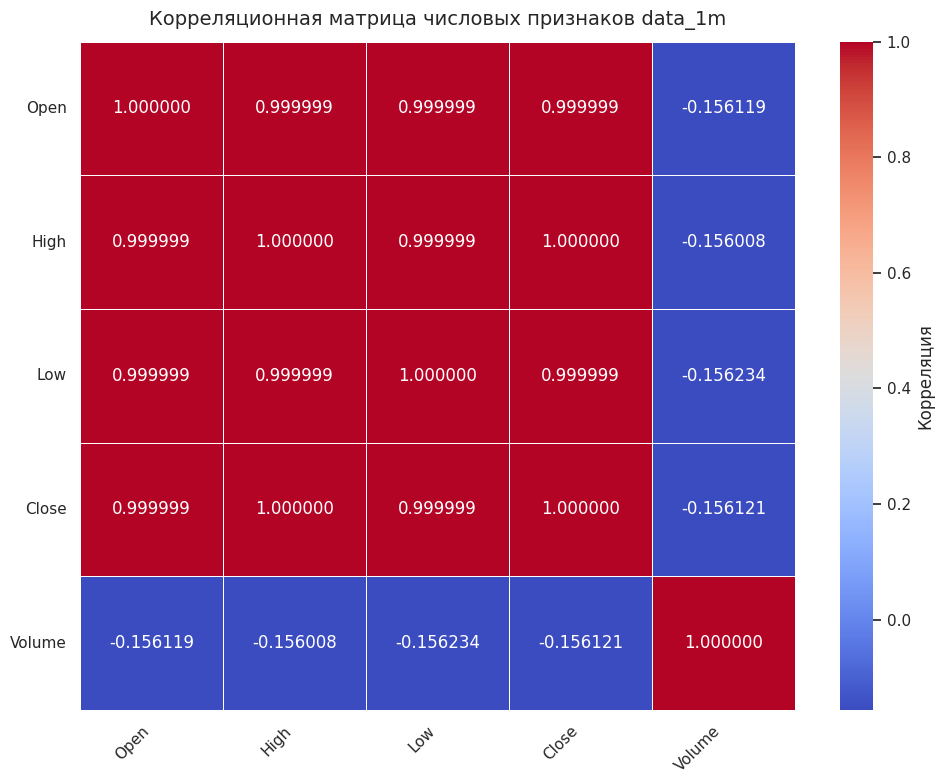

In [79]:
# Берём только числовые признаки
numeric_df = data_1m.select_dtypes(include='number')

# Считаем корреляционную матрицу
corr_matrix = numeric_df.corr()

# Показываем результат
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Рисуем тепловую карту с аннотациями
sns.heatmap(
    corr_matrix,
    annot=True,              # показывать значения корреляции
    fmt=".6f",               # формат чисел
    cmap="coolwarm",         # цветовая палитра
    linewidths=0.5,          # разделительные линии
    cbar_kws={"label": "Корреляция"}  # подпись цветовой шкалы
)

plt.title("Корреляционная матрица числовых признаков data_1m", fontsize=14, pad=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# **4. Визуализация данных**

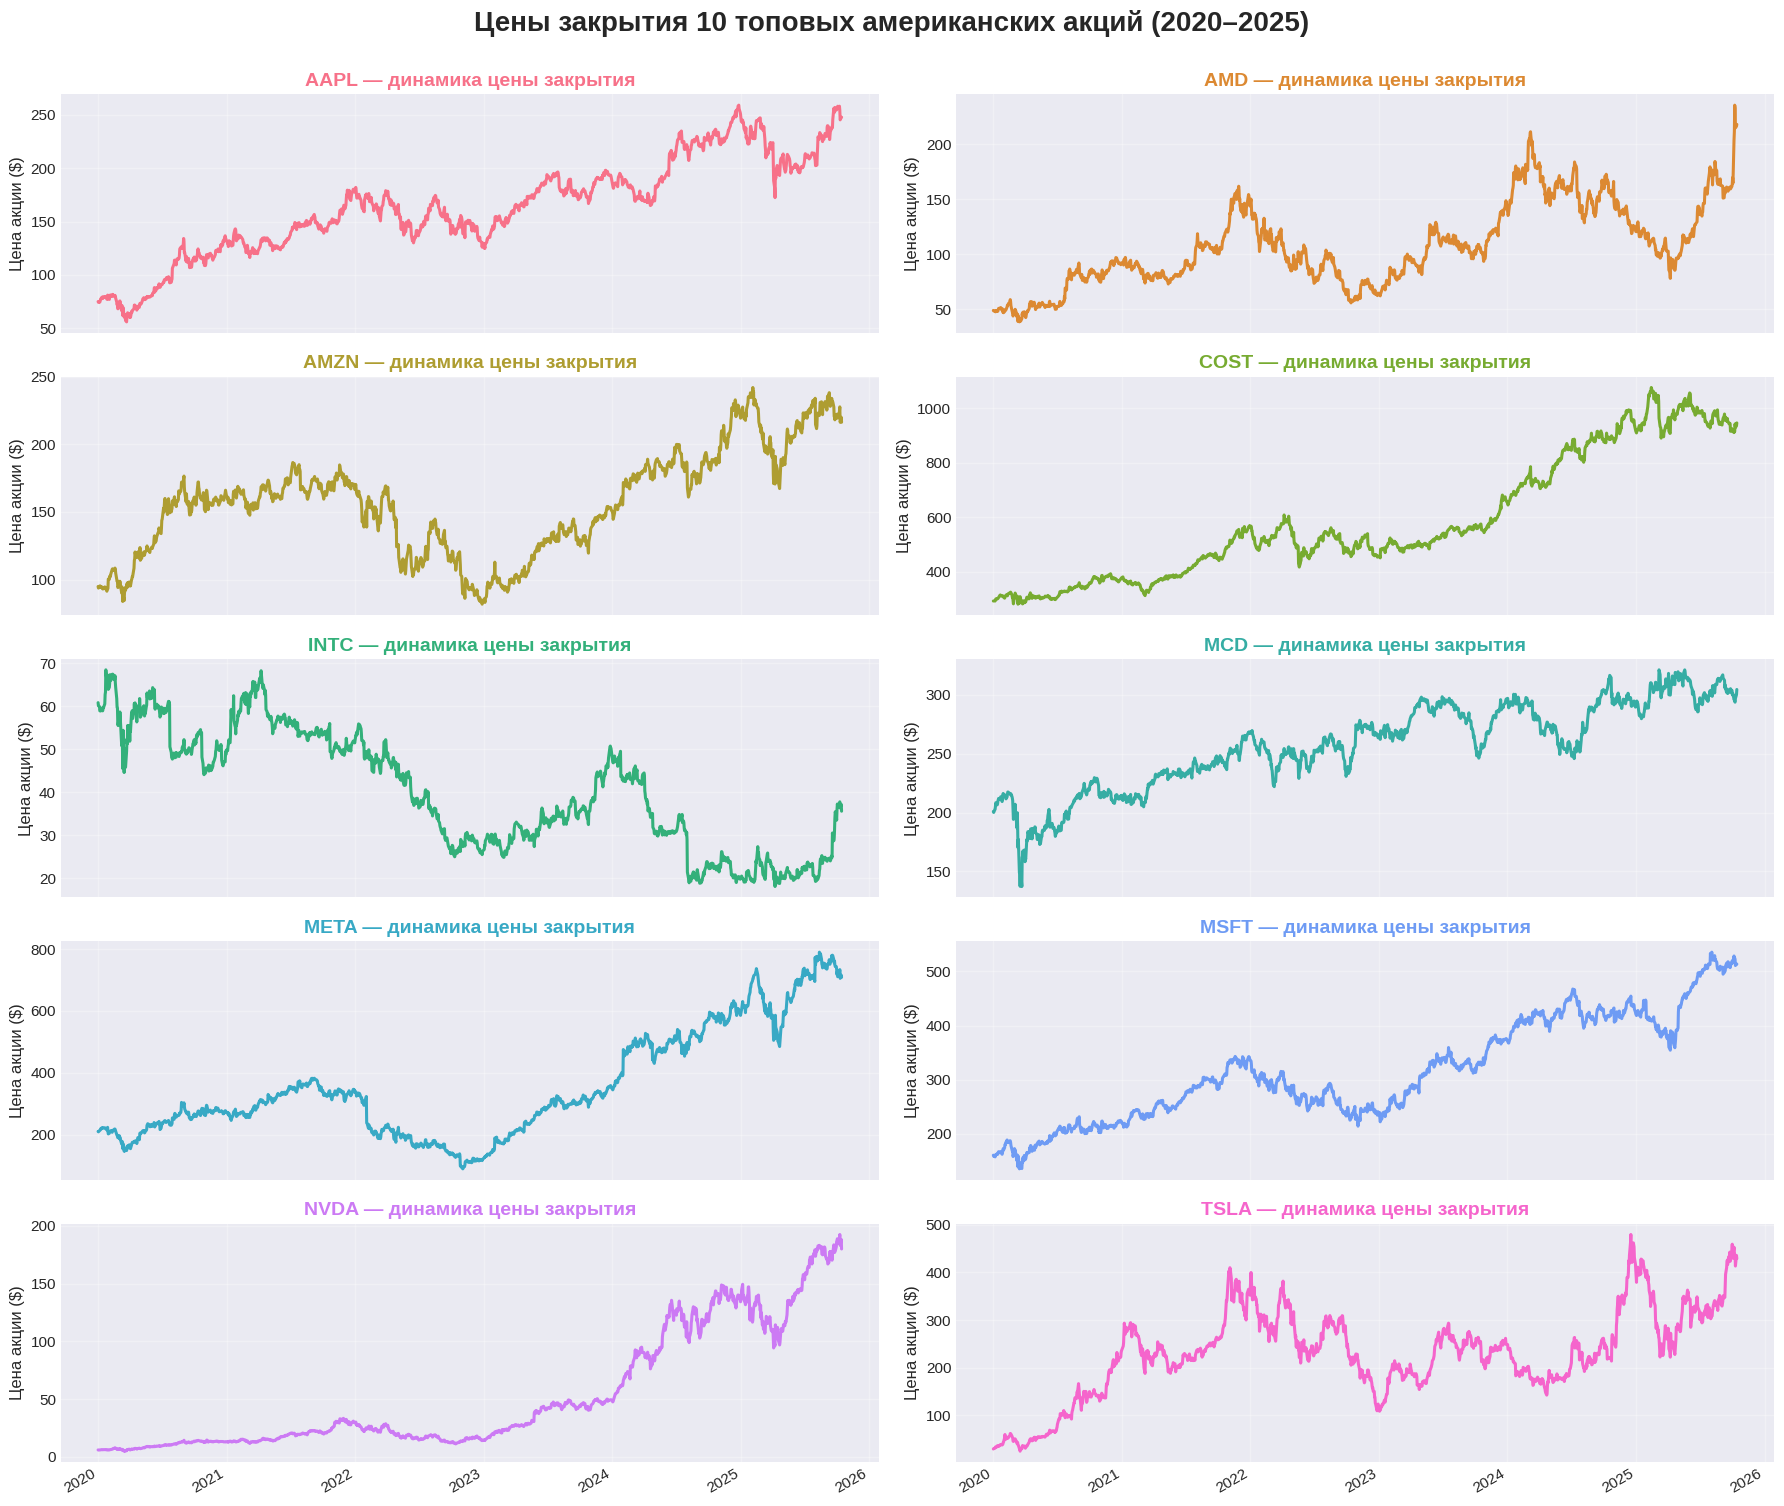

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


# Настройки отображения
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-darkgrid")

# Оставим только нужные колонки
plot_df = data[["Date", "Ticker", "Close"]].copy()
plot_df["Date"] = pd.to_datetime(plot_df["Date"])

# Список тикеров
tickers = plot_df["Ticker"].unique()

# Создаём 5x2 подграфика
fig, axes = plt.subplots(5, 2, figsize=(18, 16), sharex=True)
axes = axes.flatten()

# Цветовая палитра
palette = sns.color_palette("husl", len(tickers))

# Строим графики для каждого тикера
for i, ticker in enumerate(tickers):
    ax = axes[i]
    data_ticker = plot_df[plot_df["Ticker"] == ticker]

    sns.lineplot(
        data=data_ticker,
        x="Date",
        y="Close",
        color=palette[i],
        linewidth=2.2,
        ax=ax
    )

    # Заголовок и оформление
    ax.set_title(
        f"{ticker} — динамика цены закрытия",
        fontsize=14,
        fontweight="bold",
        color=palette[i]
    )
    ax.set_ylabel("Цена акции ($)", fontsize=12)
    ax.set_xlabel("")
    ax.grid(True, alpha=0.3)

    # даты на оси X
    for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment('right')

# Удалим лишние пустые графики (если тикеров меньше 10)
for j in range(len(tickers), len(axes)):
    fig.delaxes(axes[j])

# Финальные настройки
fig.suptitle("Цены закрытия 10 топовых американских акций (2020–2025)", fontsize=20, fontweight="bold", y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

## Добавим интерактивные графики цены закрытия:

In [39]:
import plotly.graph_objects as go
import pandas as pd

# Сначала определяем выбросы
outlier_df = detect_ohlcv_outliers(data)
outlier_df["Date"] = pd.to_datetime(outlier_df["Date"])

tickers = outlier_df["Ticker"].unique()

fig = go.Figure()
trace_count = 0

# Добавляем линии и выбросы для каждого тикера
for ticker in tickers:
    df_t = outlier_df[outlier_df["Ticker"] == ticker]

    # Линия цены
    fig.add_trace(
        go.Scatter(
            x=df_t["Date"],
            y=df_t["Close"],
            mode="lines",
            name=f"{ticker} — Цена",
            visible=(ticker == tickers[0])
        )
    )
    trace_count += 1

    # Точки выбросов
    df_out = df_t[df_t["any_outlier"] == 1]
    fig.add_trace(
        go.Scatter(
            x=df_out["Date"],
            y=df_out["Close"],
            mode="markers",
            marker=dict(color="red", size=8, symbol="circle"),
            name=f"{ticker} — Выбросы",
            visible=(ticker == tickers[0])
        )
    )
    trace_count += 1

# Обновляем меню: 2 trace на каждый тикер
buttons = []
for i, ticker in enumerate(tickers):
    visible = [False] * trace_count
    visible[i*2] = True       # линия цены
    visible[i*2 + 1] = True   # выбросы
    buttons.append(
        dict(
            label=ticker,
            method="update",
            args=[{"visible": visible},
                  {"title": f"Цена закрытия акции: {ticker} (2020–2025)"}]
        )
    )

# Настраиваем оформление
fig.update_layout(
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        x=0.02,
        y=0.95,
        xanchor='left',
        yanchor='top'
    )],
    title={
        "text": f"Цена закрытия акции: {tickers[0]} (2020–2025)",
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
        "font": {"size": 24, "family": "Arial", "color": "black"}
    },
    xaxis_title="Дата",
    yaxis_title="Цена акции ($)",
    template="plotly_white",
    height=600,
    width=1000,
    legend=dict(yanchor="top", y=1.12, xanchor="left", x=0.02)
)

fig.show()

In [40]:
import plotly.graph_objects as go
import pandas as pd


outlier_df = detect_ohlcv_outliers(data)
outlier_df["Date"] = pd.to_datetime(outlier_df["Date"])

tickers = outlier_df["Ticker"].unique()

fig = go.Figure()
trace_count = 0

# --- Добавляем свечи и выбросы для каждого тикера ---
for ticker in tickers:
    df_t = outlier_df[outlier_df["Ticker"] == ticker].sort_values("Date")

    # Свечной график
    fig.add_trace(
        go.Candlestick(
            x=df_t["Date"],
            open=df_t["Open"],
            high=df_t["High"],
            low=df_t["Low"],
            close=df_t["Close"],
            increasing_line_color="green",
            decreasing_line_color="red",
            name=f"{ticker} — Свечи",
            visible=(ticker == tickers[0])
        )
    )

    # fig.update_xaxes(type='category', tickformat="%Y-%m-%d")
    trace_count += 1

    # Точки выбросов (если есть)
    df_out = df_t[df_t["any_outlier"] == 1]
    fig.add_trace(
        go.Scatter(
            x=df_out["Date"],
            y=df_out["Close"],
            mode="markers",
            marker=dict(color="black", size=8, symbol="circle"),
            name=f"{ticker} — Выбросы",
            visible=(ticker == tickers[0])
        )
    )
    trace_count += 1



# Меню для переключения тикеров
buttons = []
for i, ticker in enumerate(tickers):
    visible = [False] * trace_count
    visible[i*2] = True        # Свечи
    visible[i*2 + 1] = True    # Выбросы
    buttons.append(
        dict(
            label=ticker,
            method="update",
            args=[
                {"visible": visible},
                {"title": f"Свечной график акций {ticker} (2020–2025)"}
            ]
        )
    )

#  Оформление
fig.update_layout(
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        x=0.02,
        y=0.95,
        xanchor='left',
        yanchor='top'
    )],
    title={
        "text": f"Свечной график акций {tickers[0]} (2020–2025)",
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
        "font": {"size": 24, "family": "Arial", "color": "black"}
    },
    xaxis_title="Дата",
    yaxis_title="Цена акции ($)",
    template="plotly_white",
    height=700,
    width=1100,
    legend=dict(yanchor="top", y=1.12, xanchor="left", x=0.02),
    xaxis_rangeslider_visible=False  # скрыть нижний слайдер
)

fig.show()

## Посмотрим на интерактивные графики дневной доходности:

In [41]:
import plotly.graph_objects as go
import pandas as pd

# Считаем выбросы
outlier_df = detect_ohlcv_outliers(data)
outlier_df["Date"] = pd.to_datetime(outlier_df["Date"])

# Переведём доходность в проценты
outlier_df["Return_pct"] = outlier_df["Return"] * 100

tickers = outlier_df["Ticker"].unique()
fig = go.Figure()
trace_count = 0

# Добавляем линии доходности и точки выбросов
for ticker in tickers:
    df_t = outlier_df[outlier_df["Ticker"] == ticker]

    # Линия доходности
    fig.add_trace(
        go.Scatter(
            x=df_t["Date"],
            y=df_t["Return_pct"],
            mode="lines",
            name=f"{ticker} — Доходность",
            visible=(ticker == tickers[0])
        )
    )
    trace_count += 1

    # Точки выбросов по доходности
    df_out = df_t[df_t["price_outlier"] == 1]
    fig.add_trace(
        go.Scatter(
            x=df_out["Date"],
            y=df_out["Return_pct"],
            mode="markers",
            marker=dict(color="red", size=8, symbol="circle"),
            name=f"{ticker} — Выбросы доходности",
            visible=(ticker == tickers[0])
        )
    )
    trace_count += 1

# Меню для переключения тикеров
buttons = []
for i, ticker in enumerate(tickers):
    visible = [False] * trace_count
    visible[i*2] = True       # линия доходности
    visible[i*2 + 1] = True   # выбросы доходности
    buttons.append(
        dict(
            label=ticker,
            method="update",
            args=[{"visible": visible},
                  {"title": f"Доходность акции: {ticker} (в % за период)"}]
        )
    )

# Настройки графика
fig.update_layout(
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        x=0.02,
        y=0.95,
        xanchor='left',
        yanchor='top'
    )],
    title={
        "text": f"Доходность акции: {tickers[0]} (в % за период)",
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
        "font": {"size": 24, "family": "Arial", "color": "black"}
    },
    xaxis_title="Дата",
    yaxis_title="Доходность (%)",
    template="plotly_white",
    height=600,
    width=1000,
    legend=dict(yanchor="top", y=1.12, xanchor="left", x=0.02)
)

fig.show()

## Структурные сдвиги

**Структурные сдвиги** — это резкие и устойчивые изменения в поведении временного ряда, которые меняют его базовые характеристики (например, среднее значение, дисперсию, тренд или сезонность). В отличие от краткосрочных выбросов, такие изменения носят **долговременный характер** и часто отражают фундаментальные изменения во внешней среде или в самой системе.

### Общая идея задачи:

У нас есть временной ряд:  
$$y_1, y_2, \dots, y_T$$

Мы хотим разделить его на сегменты так, чтобы внутри каждого сегмента данные были «однородны» (например, имели одинаковое среднее и дисперсию).

Формально, нужно найти точки разрыва (*changepoints*):  
$$\tau_0 = 0 < \tau_1 < \tau_2 < \dots < \tau_m < \tau_{m+1} = T$$

Эти точки делят временной ряд на \(m + 1\) сегментов:  
$$ (\tau_{k-1} + 1 : \tau_k), \quad k = 1, \dots, m + 1 $$


---

### Основные методы:

1. PELT - универсален для работы с финансовыми рядами. Чаще всего используется именно он. Есть возможность выбирать ядра в качестве стоимостной функции. Также есть возможность выявления многомерной зависимости
2. CUSUM - плохо работает при трендах
3. Chow Test - Сравнение регрессий до и после точки (анализ одной точки)
4. Bai-Perron - Эконометрический метод на основе F-тестов для регрессии с разрывами (очень точный, статистически строгий). Однако вместо него чаще всего используется PELT + L2
5. KernelCPD - Непараметрический метод поиска точек структурных сдвигов, основанный на сравнении распределений данных до и после потенциальной точки разрыва в ядровом пространстве

Реализуем 2 метода PELT и KernelCPD для поиска структурных разрывов, так как оба алгоритма не требует стационарности и улавливают нелинейные зависимости:



In [42]:
!pip install ruptures

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.8 MB/s eta 0:00:00


### **Алгоритм PELT (Pruned Exact Linear Time)**. Основная идея

1. **Функция стоимости**  
Мы ищем точки разрыва, минимизируя суммарную стоимость сегментации:

$$
\min_{\tau_1, \dots, \tau_m} \left[ \sum_{k=0}^{m} C(\tau_k, \tau_{k+1}) + \beta m \right]
$$

где:  
- $C(\tau_k, \tau_{k+1})$ — функция стоимости (например, ошибка аппроксимации) для сегмента $ [\tau_k, \tau_{k+1}] $. В качестве функции стоимости для финансовых данных чаще всего берут "rbf"
- $beta$ — штраф за добавление новой точки разрыва (регулирует их количество)

---

2. **Динамическое программирование**  
Оптимальная сегментация находится с помощью рекуррентного соотношения:

$$
F(t) = \min_{s < t} \left[ F(s) + C(s, t) + \beta \right]
$$

где: $ F(t) $ — минимальная стоимость сегментации для первых $ t $ точек.

---

3. **Прореживание (Pruning)**  
Для ускорения алгоритма исключаются кандидаты \( s \), которые не могут быть оптимальными:

$$
F(s) + C(s, t) + \beta \geq F(t)
$$

Это сокращает сложность с $ O(T^2) $ до $ O(T) $.

---

4. **Результат**  
PELT находит точки, при которых структура временного ряда (например, среднее, дисперсия или их комбинация) меняется наиболее вероятно.


In [43]:
import ruptures as rpt


def detect_structural_breaks_pelt(
    df: pd.DataFrame,
    target_cols=["Close"],
    cost_model="rbf",
    penalty=3,
    min_size=20
):
    """
    Выявляет структурные сдвиги (changepoints) для временных рядов OHLCV по тикерам с помощью PELT.

    Параметры:
    df : pd.DataFrame
        Данные в длинном формате с колонками ['Date' или 'Datetime', 'Ticker', ...]
    target_cols : list
        Список колонок, по которым ищем структурные сдвиги (может быть одна или несколько)
    cost_model : str
        Функция стоимости: 'l2', 'normal', 'rbf', 'linear', 'rank' и др.
    penalty : float
        Параметр штрафа за количество разрывов (чем больше - тем меньше сегментов)
    min_size : int
        Минимальная длина сегмента (защита от ложных сдвигов)

    Возвращает:
    pd.DataFrame с исходными данными и новыми колонками:
    - 'segment_id' : номер сегмента после разбиения
    - 'changepoint' : 1 если наблюдение является точкой разрыва
    """

    df = df.copy()
    time_col = "Datetime" if "Datetime" in df.columns else "Date"
    df[time_col] = pd.to_datetime(df[time_col])
    results = []

    # Обрабатываем каждый тикер отдельно
    for ticker, group in df.groupby("Ticker"):
        group = group.sort_values(time_col).reset_index(drop=True)

        X = group[target_cols].values  # Создаём матрицу признаков

        # Инициализируем модель PELT
        model = rpt.Pelt(model=cost_model, min_size=min_size).fit(X)
        breakpoints = model.predict(pen=penalty)

        # Превращаем список разрывов в разметку сегментов
        segment_id = np.zeros(len(group), dtype=int)
        changepoint_flags = np.zeros(len(group), dtype=int)

        current_segment = 0
        prev_bp = 0
        for bp in breakpoints:
            segment_id[prev_bp:bp] = current_segment
            if bp < len(changepoint_flags):
                changepoint_flags[bp - 1] = 1
            prev_bp = bp
            current_segment += 1

        group["segment_id"] = segment_id
        group["changepoint"] = changepoint_flags
        group["n_changepoints"] = len(breakpoints) - 1
        results.append(group)

    return pd.concat(results, ignore_index=True)


### **Алгоритм KernelCPD (Kernel Change Point Detection)**. Основная идея

Алгоритм Kernel Change Point Detection — это непараметрический метод поиска точек структурных сдвигов, основанный на сравнении распределений данных до и после потенциальной точки разрыва в **ядровом пространстве**.

---

#### 1. Постановка задачи

Пусть дан временной ряд:
$$
\{ y_1, y_2, \dots, y_T \}
$$

Мы хотим найти такие точки:
$$
0 = \tau_0 < \tau_1 < \dots < \tau_m < \tau_{m+1} = T
$$

которые делят ряд на $m+1$ сегментов, внутри которых распределение данных является «стационарным» или «однородным».

---

#### 2. Отображение в ядровое пространство

Выбирается положительно определённое ядро $k(\cdot, \cdot)$, например, гауссовское (RBF):

$$
k(x_i, x_j) = \exp\left(-\frac{\|x_i - x_j\|^2}{2\sigma^2}\right)
$$

и строится матрица Грама:
$$
K_{ij} = k(y_i, y_j)
$$

Тем самым данные переносятся в пространство признаков, где различия между распределениями становятся более заметными.

---

#### 3. Функция стоимости

Цель алгоритма — минимизировать **внутрисегментную дисперсию** в ядровом пространстве:

$$
\mathcal{C}(\tau_1, \dots, \tau_m) =
\sum_{k=0}^m \sum_{i,j=\tau_k+1}^{\tau_{k+1}}
\left[ K_{ij} - \frac{1}{\tau_{k+1} - \tau_k} \sum_{p,q=\tau_k+1}^{\tau_{k+1}} K_{pq} \right]
$$

Чем меньше эта сумма, тем более однородны сегменты.

---

#### 4. Оптимизация

Искомые точки разрыва находятся из задачи оптимизации:

$$
\min_{\tau_1, \dots, \tau_m} \mathcal{C}(\tau_1, \dots, \tau_m)
$$

с дополнительным ограничением:

$$
\tau_{k+1} - \tau_k \geq L_{\min}
$$

где $L_{\min}$ — минимальная длина сегмента.

---

#### 5. Интерпретация

- Метод не предполагает конкретной формы распределения данных.  
- Он способен обнаруживать не только скачки среднего или дисперсии, но и более сложные изменения в структуре распределения.  
- Выбор ядра (например, RBF) позволяет «заметить» изменения, невидимые для параметрических методов.

---

**Вывод:** KernelCPD ищет такие точки $\tau_k$, в которых распределение данных в ядровом пространстве существенно изменяется. Это делает его особенно полезным для анализа финансовых временных рядов, где изменения могут происходить не только в уровне или волатильности, но и в самой структуре данных.


In [44]:
import ruptures as rpt


def detect_kernel_changepoints(
    df: pd.DataFrame,
    target_cols=["Close"],
    kernel="rbf",
    n_bkps=5,
    min_size=30
):
    """
    Поиск структурных сдвигов методом Kernel Change Point Detection + разметка сегментов.

    Параметры:
    -----------
    df : pd.DataFrame
        Данные в формате long с колонками ['Date', 'Ticker', ...]
    target_cols : list
        Какие признаки использовать для анализа (можно несколько)
    kernel : str
        Тип ядра ('rbf', 'linear', 'poly', ...)
    n_bkps : int
        Максимальное количество точек разрыва
    min_size : int
        Минимальный размер сегмента

    Возвращает:
    -----------
    result_df : pd.DataFrame
        DataFrame с колонками changepoint (0/1) и segment_id (int)
    """
    results = []

    for ticker, group in df.groupby("Ticker"):
        group = group.sort_values("Date").reset_index(drop=True)
        X = group[target_cols].values

        # --- Детекция структурных сдвигов ---
        model = rpt.KernelCPD(kernel=kernel, min_size=min_size).fit(X)
        bkps = model.predict(n_bkps=n_bkps)

        # --- Метка точек сдвига ---
        group["changepoint"] = 0
        for bkp in bkps[:-1]:  # последний элемент = конец ряда
            group.loc[bkp, "changepoint"] = 1

        # --- Разметка сегментов ---
        segment_ids = np.zeros(len(group), dtype=int)
        current_segment = 0
        last_bkp = 0
        for bkp in bkps:
            segment_ids[last_bkp:bkp] = current_segment
            current_segment += 1
            last_bkp = bkp
        group["segment_id"] = segment_ids

        results.append(group)

    return pd.concat(results, ignore_index=True)

Посмотрим пример работы двух алгоритмов:

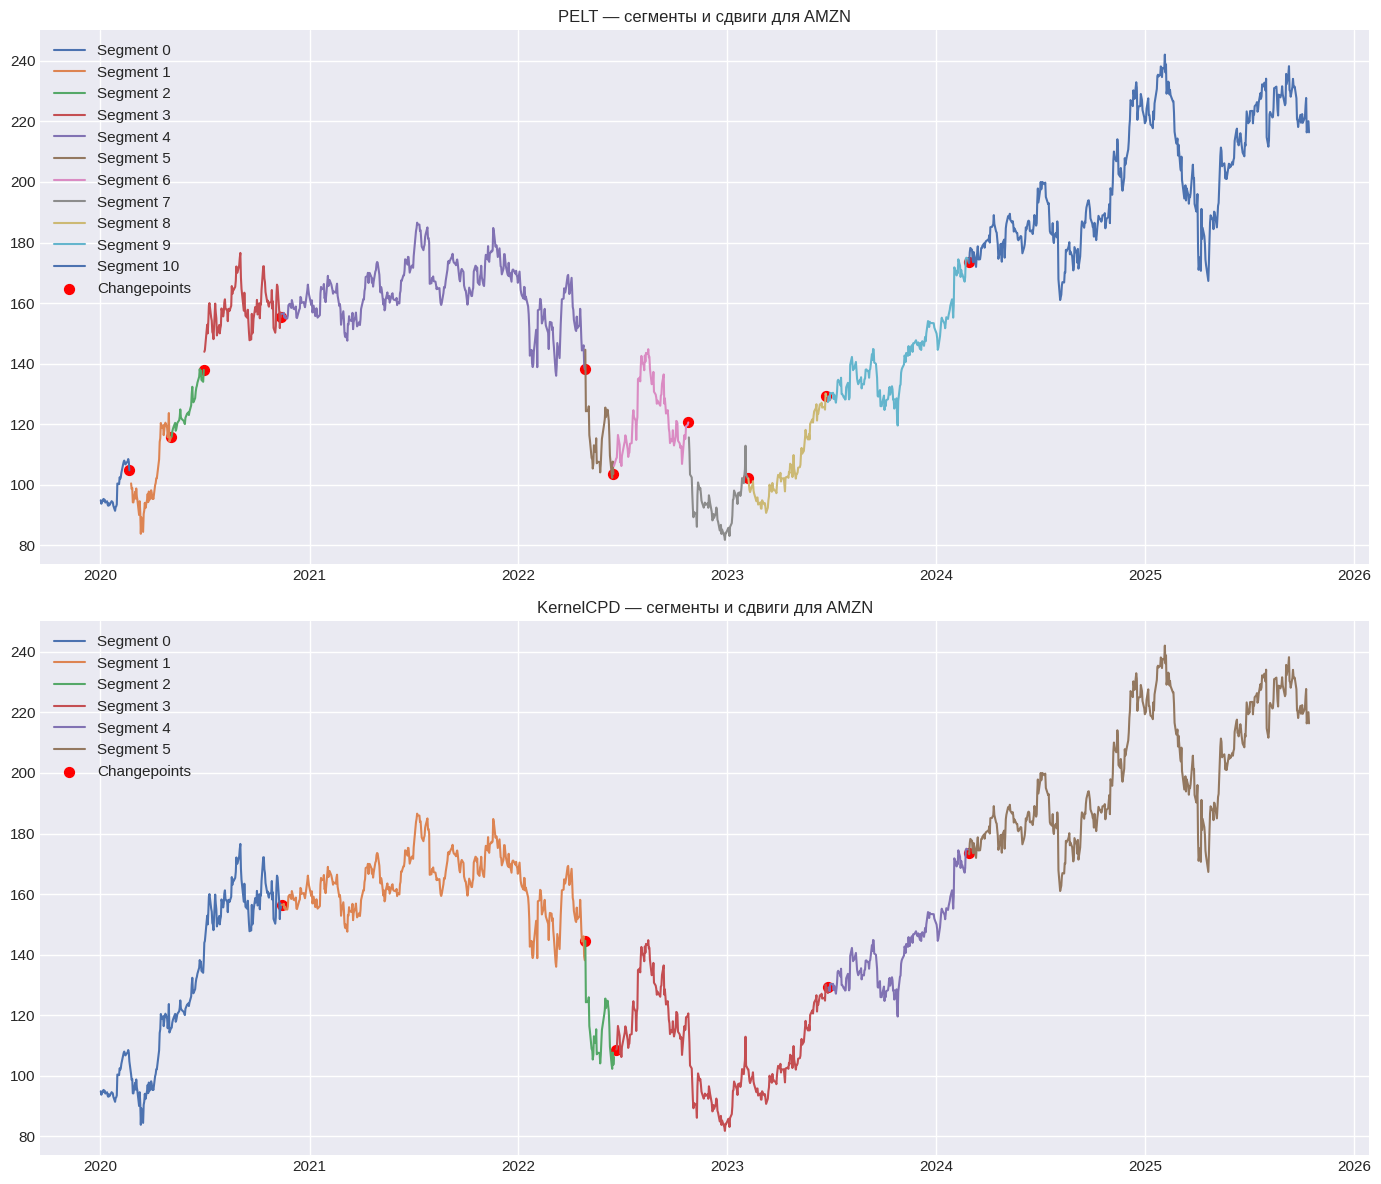

In [45]:
import matplotlib.pyplot as plt

# PELT
data_pelt = data.drop(columns=["segment_id", "changepoint"], errors="ignore").copy()

pelt_result = detect_structural_breaks_pelt(
    df=data_pelt,
    target_cols=["Close", "Volume"],
    cost_model="rbf",
    penalty=5,
    min_size=30
)

ticker = "AMZN"
df_pelt = pelt_result[pelt_result["Ticker"] == ticker].copy()

plt.figure(figsize=(14, 12))

# ВЕРХНИЙ график: PELT
plt.subplot(2, 1, 1)
for seg_id, seg_df in df_pelt.groupby("segment_id"):
    plt.plot(seg_df["Date"], seg_df["Close"], label=f"Segment {seg_id}")
plt.scatter(
    df_pelt[df_pelt["changepoint"] == 1]["Date"],
    df_pelt[df_pelt["changepoint"] == 1]["Close"],
    color="red", s=50, label="Changepoints"
)
plt.title(f"PELT — сегменты и сдвиги для {ticker}")
plt.legend()
plt.grid(True)


# KernelCPD
data_kernel = data.drop(columns=["segment_id", "changepoint"], errors="ignore").copy()

kcp_result = detect_kernel_changepoints(
    df=data_kernel,
    target_cols=["Close", "Volume"],
    kernel="rbf",
    n_bkps=5,
    min_size=1
)

df_kernel = kcp_result[kcp_result["Ticker"] == ticker].copy()

# НИЖНИЙ график: KernelCPD
plt.subplot(2, 1, 2)
for seg_id, seg_df in df_kernel.groupby("segment_id"):
    plt.plot(seg_df["Date"], seg_df["Close"], label=f"Segment {seg_id}")
plt.scatter(
    df_kernel[df_kernel["changepoint"] == 1]["Date"],
    df_kernel[df_kernel["changepoint"] == 1]["Close"],
    color="red", s=50, label="Changepoints"
)
plt.title(f"KernelCPD — сегменты и сдвиги для {ticker}")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()